In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# GM0 Performance Evaluation

**IMPORTANT**: This notebook should be used as a base for the evaluation of different models. 

- Please **make a copy of this notebook** whenever you want to evaluate a model. Load the desired model by changing the following `model_path_str` variable. 
- This notebook is currently not saving any generated plot. Please make sure to not overwrite the outputs, or to save the plots whenever needed. 
- This notebook saves the generated data. Please refer to the Evaluation section of this notebook. 

Available models on the SDSC shared folder: 

In [3]:
!ls /store/sdsc/sd28/models/GM0/diffusion/

1D-UNET-DDPM-envelope
consistency-model-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05
ddim-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05
ddim-pred:epsilon-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05
ddim-pred:epsilon-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:1_LogSpectrogram-{}
ddim-pred:sample-1D-downsampling:1_SignalWithEnvelope-first_order_lp-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:1_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:1_SignalWithEnvelope-moving_average-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:2_LogSpectrogram-{}
ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-first_order_lp-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-dow

In [1]:
models_folder = "../outputs/"

One can either choose a specific checkpoint of a model or the most recent checkpoint of that model (default):

In [2]:
# Pick the last checkpoint of the model
model_path_str = models_folder + "ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average-scale:2-log-log_offset:1.0e-07-standardize-scalar:True"

# Or pick a specific checkpoint
# model_path_str = dataset_folder + "/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average_shifted-log-log_offset:1.0e-05-normalize-scalar:True/name=0_epoch=125-val_loss=0.02.ckpt"

Import the needed libraries, modules and needed variables

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

from pathlib import Path
from tqdne.utils import *
from tqdne.conf import Config
from tqdne.metric import *

from tqdne.dataset import RepresentationDataset 
from torch.utils.data import DataLoader, ConcatDataset


/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else: 
    device = torch.device('cpu')

torch.cuda.is_available(), device

(True, device(type='cuda'))

In [5]:
config = Config()

# Select the signal length
signal_length = config.signal_length 

# Set the sampling frequency
fs = config.fs

# Set the number of channels of the original waveforms  
n_channels = config.num_channels

# Set the conditioning parameters range
cond_params_range = config.conditional_params_range

Load the model

2024-07-01 15:45:02 - root - INFO - Last checkpoint is : ../outputs/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average-scale:2-log-log_offset:1.0e-07-standardize-scalar:True/name=0_epoch=284-val_loss=0.17.ckpt
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


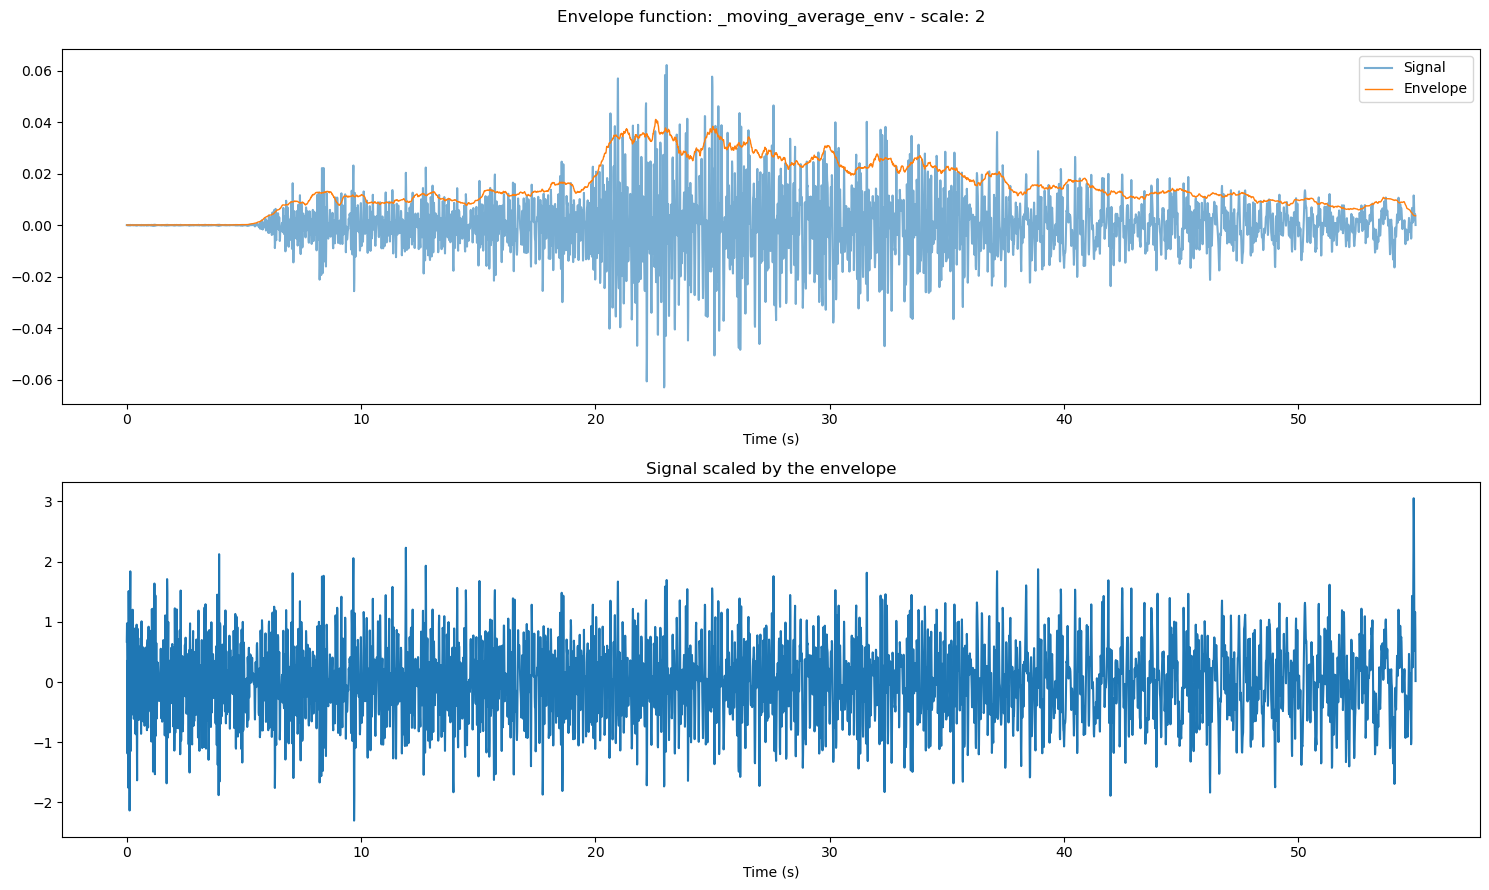

Model: LightningDiffusion
Number of learnable parameters: 9704198
Model size: 117.02 MB
UNet scheme: 
 base num. channels: 32 
 channel multipliers (down/up blocks): (1, 2, 4, 8) 
 num. ResBlocks per down/up block: 2 
 use Attention: True 
 conv. kernel size: 5 
Diffusion prediction type: sample
Learning rate schedule: 
 start: 0.0003 
 scheduler: cosine 
 warmup steps: 400
Batch size: 160
Downsampling factor: 2. The model was trained on signals with length 2750, as the sampling rate used was 50 instead of 100
Data representation shape: (1, 6, 2750) - (batch_size, channels, signal_length)
Data representation name: SignalWithEnvelope
Checkpoint: ../outputs/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average-scale:2-log-log_offset:1.0e-07-standardize-scalar:True/name=0_epoch=284-val_loss=0.17.ckpt - Last modified: 2024-06-23 02:19


In [6]:
model, model_data_repr, ckpt = load_model(Path(model_path_str), use_ddim=False)
model.to(device)
model.eval()
print_model_info(model, model_data_repr, ckpt)

In [7]:
!ls -al ../outputs/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average-scale:2-log-log_offset:1.0e-07-standardize-scalar:True/name=0_epoch=284-val_loss=0.17.ckpt


-rw-r--r-- 1 abosisio sd28 117018207 Jun 23 02:19 '../outputs/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average-scale:2-log-log_offset:1.0e-07-standardize-scalar:True/name=0_epoch=284-val_loss=0.17.ckpt'


Restore the sampling rate and signal length that were used during training

In [8]:
if "downsampling" in model_path_str:
    downsampling = int(model_path_str.split("downsampling:")[1].split("_")[0])
    signal_length = signal_length // downsampling
    fs = fs // downsampling
    config.signal_length = signal_length
    config.fs = fs
    print(f"Updated signal length: {config.signal_length} and fs: {config.fs}")
else:
    downsampling = 1    

Updated signal length: 2750 and fs: 50


Let's generate a batch of data

In [9]:
# Select the batch size.
batch_size = model.hparams.optimizer_params.batch_size

# One can also choose the batch size
# batch_size = 32

batch_size = batch_size*2
batch_size

320

In [14]:
# Insert values for the conditional input parameters.
# Please read generate_cond_inputs documentation (in utils.py) to understand the structure of cond_input_params dictionary
cond_input_params = {
    "hypocentral_distance": [10, 100, 150],
    "is_shallow_crustal": [0],
    "magnitude": [5.5, 4, 7, 8.5],
    "vs30": None,
}

data_raw = generate_data(model, model_data_representation=model_data_repr, raw_output=True, num_samples=batch_size, cond_input_params=cond_input_params, device=device.type)
data_raw['waveforms'].shape, data_raw['cond'].shape

Batch 1/2


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Batch 2/2


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


((320, 6, 2750), (320, 4))

In [12]:
data_raw_wf = data_raw['waveforms']
data_raw_wf.shape

(320, 6, 2750)

In [13]:
data_wf = model_data_repr.invert_representation(data_raw_wf)
data_wf.shape

(320, 3, 2750)

## Single Sample Visualization

Let's investigate model's raw output 

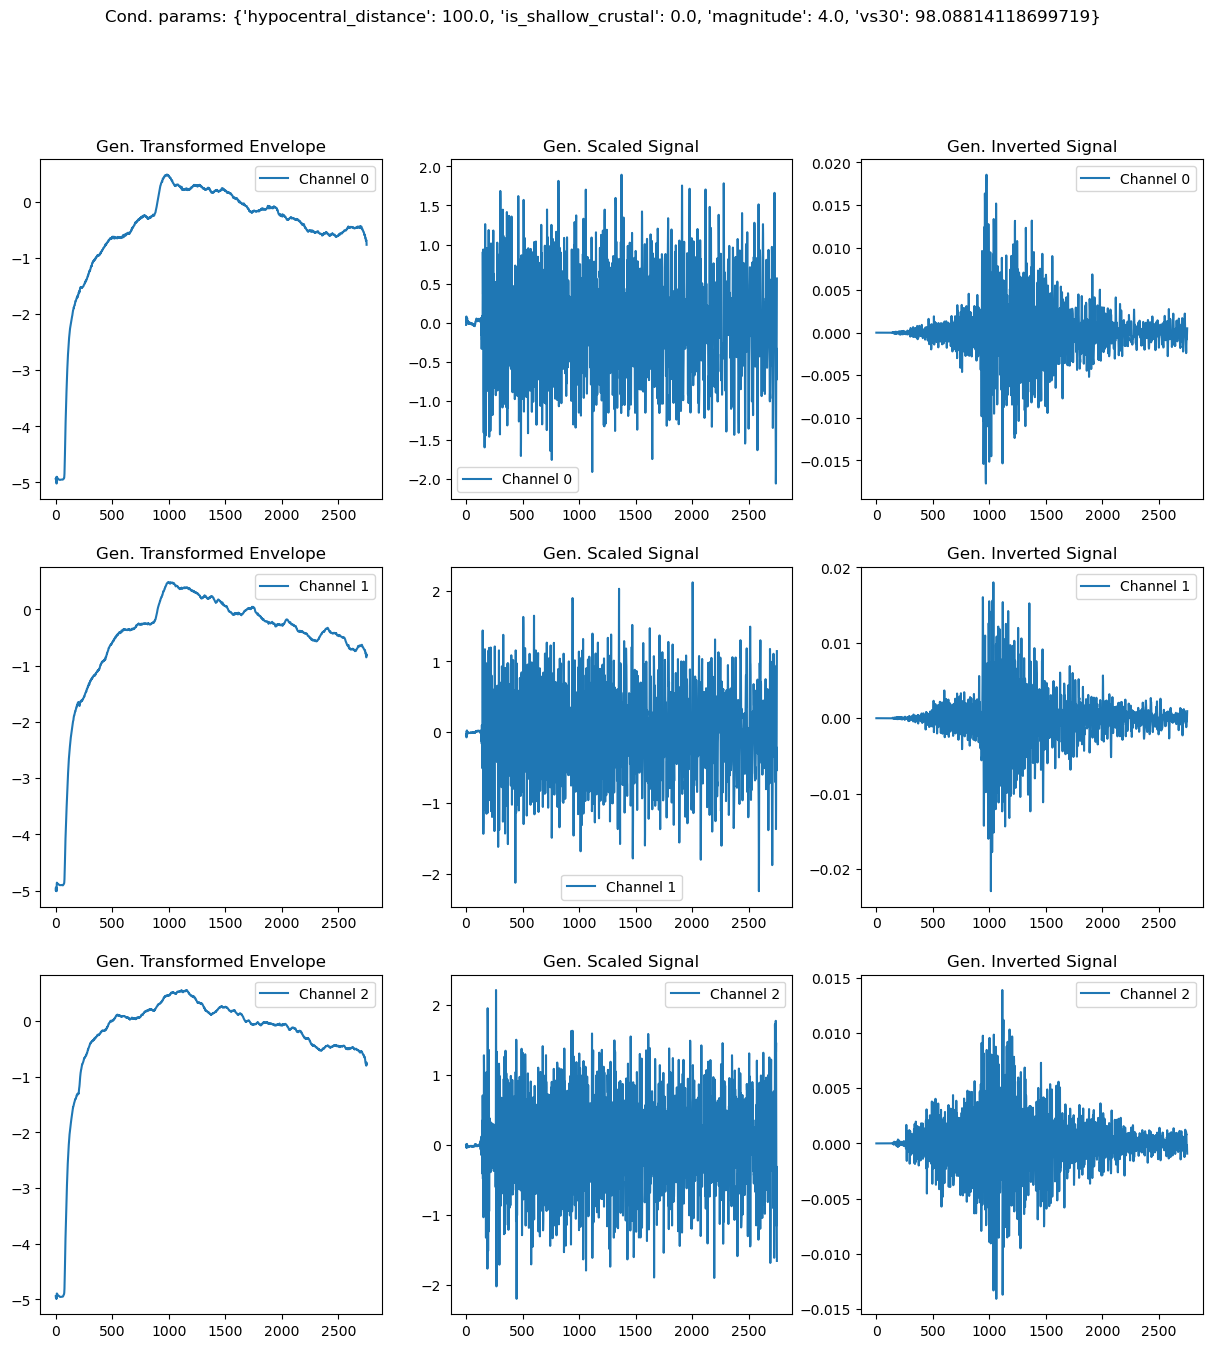

In [14]:
sample_index = 0
plot_raw_waveform(data_raw_wf[sample_index], data_raw['cond'][sample_index], model_data_repr, data_wf[sample_index])

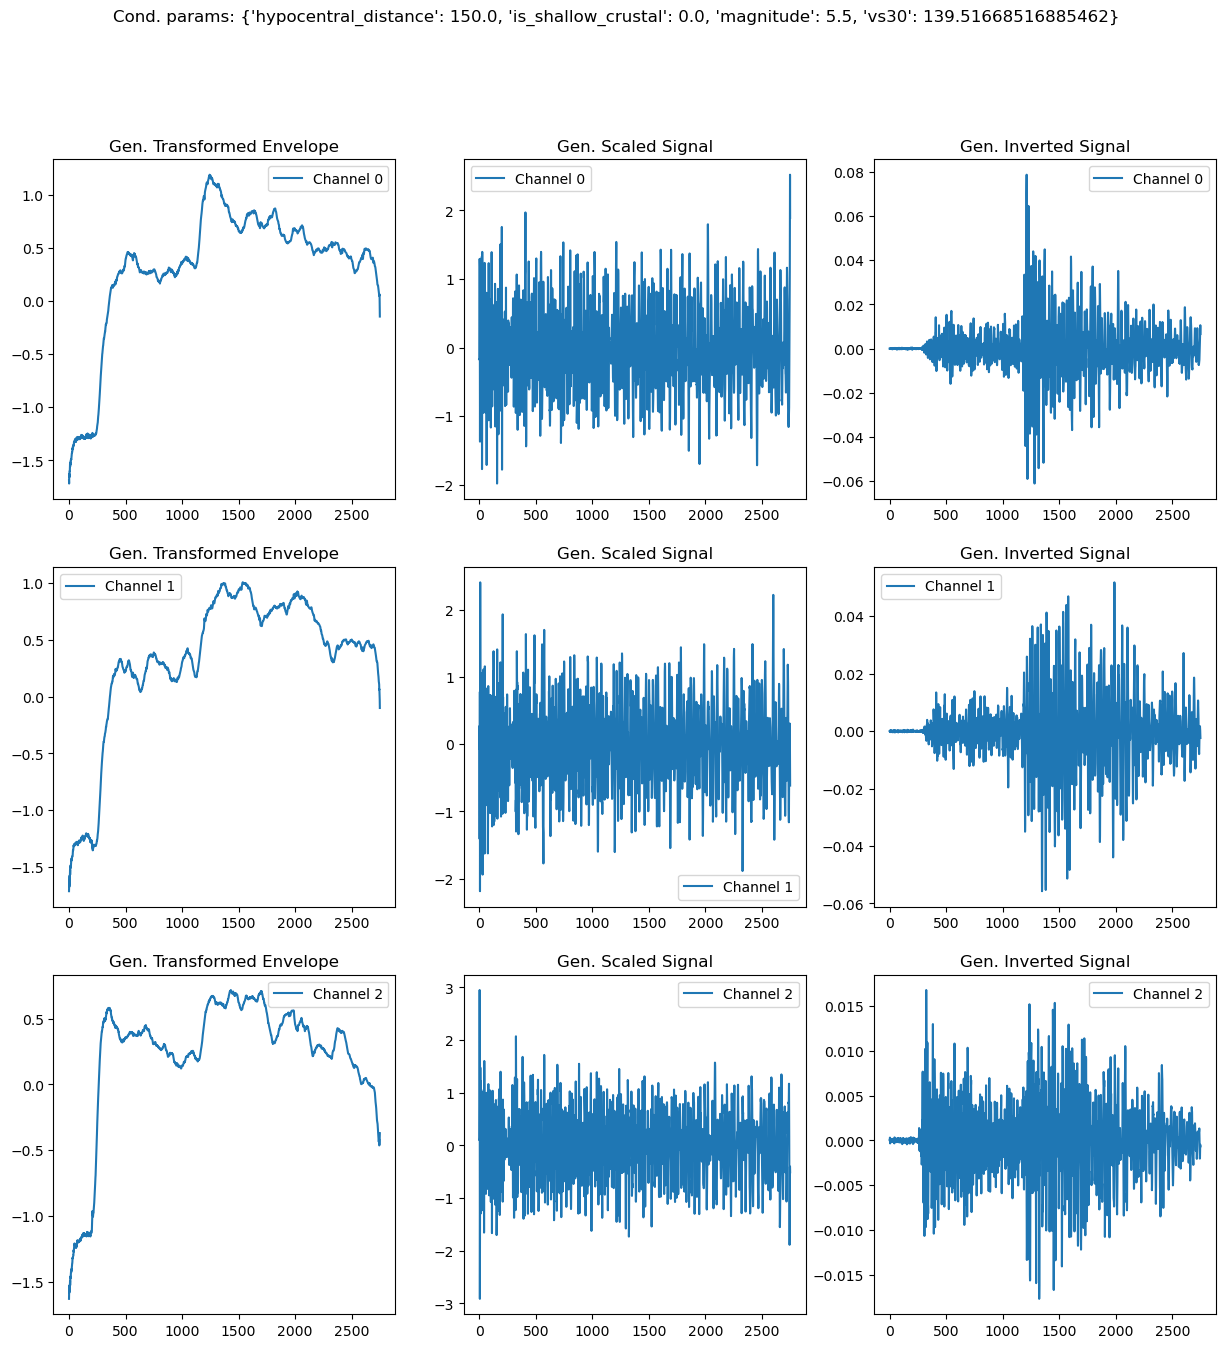

In [15]:
sample_index = 3
plot_raw_waveform(data_raw_wf[sample_index], data_raw['cond'][sample_index], model_data_repr, data_wf[sample_index])

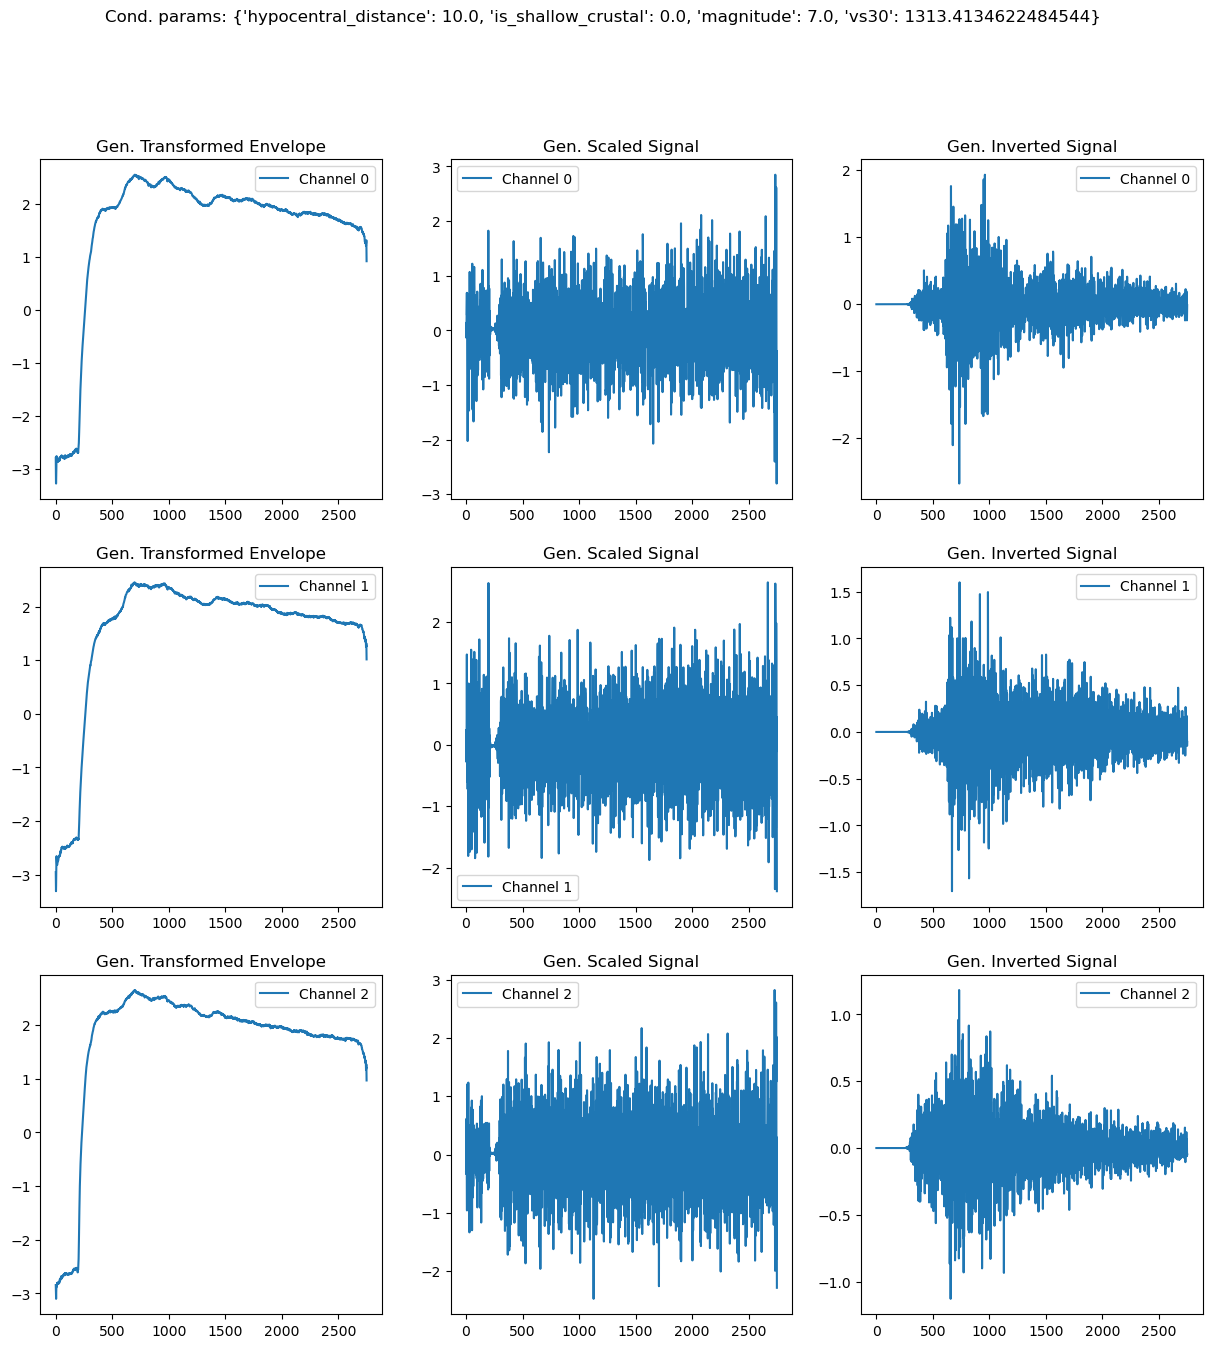

In [16]:
sample_index = 10
plot_raw_waveform(data_raw_wf[sample_index], data_raw['cond'][sample_index], model_data_repr, data_wf[sample_index])

In [17]:
# TODO: works only for 1D signals, need to generalize to 2D signals. However, is only useful for 1D signals.
# max_peak_index = np.argmax(np.max(np.abs(data_raw_wf), axis=(1, 2)))
# plot_raw_waveform(data_raw_wf[max_peak_index], n_channels, data_wf[max_peak_index])

Let's now see the generated waveforms, along with their Power Spectral Density and Log Envelope. 

In [18]:
data = {"waveforms": data_wf, "cond": data_raw['cond']}

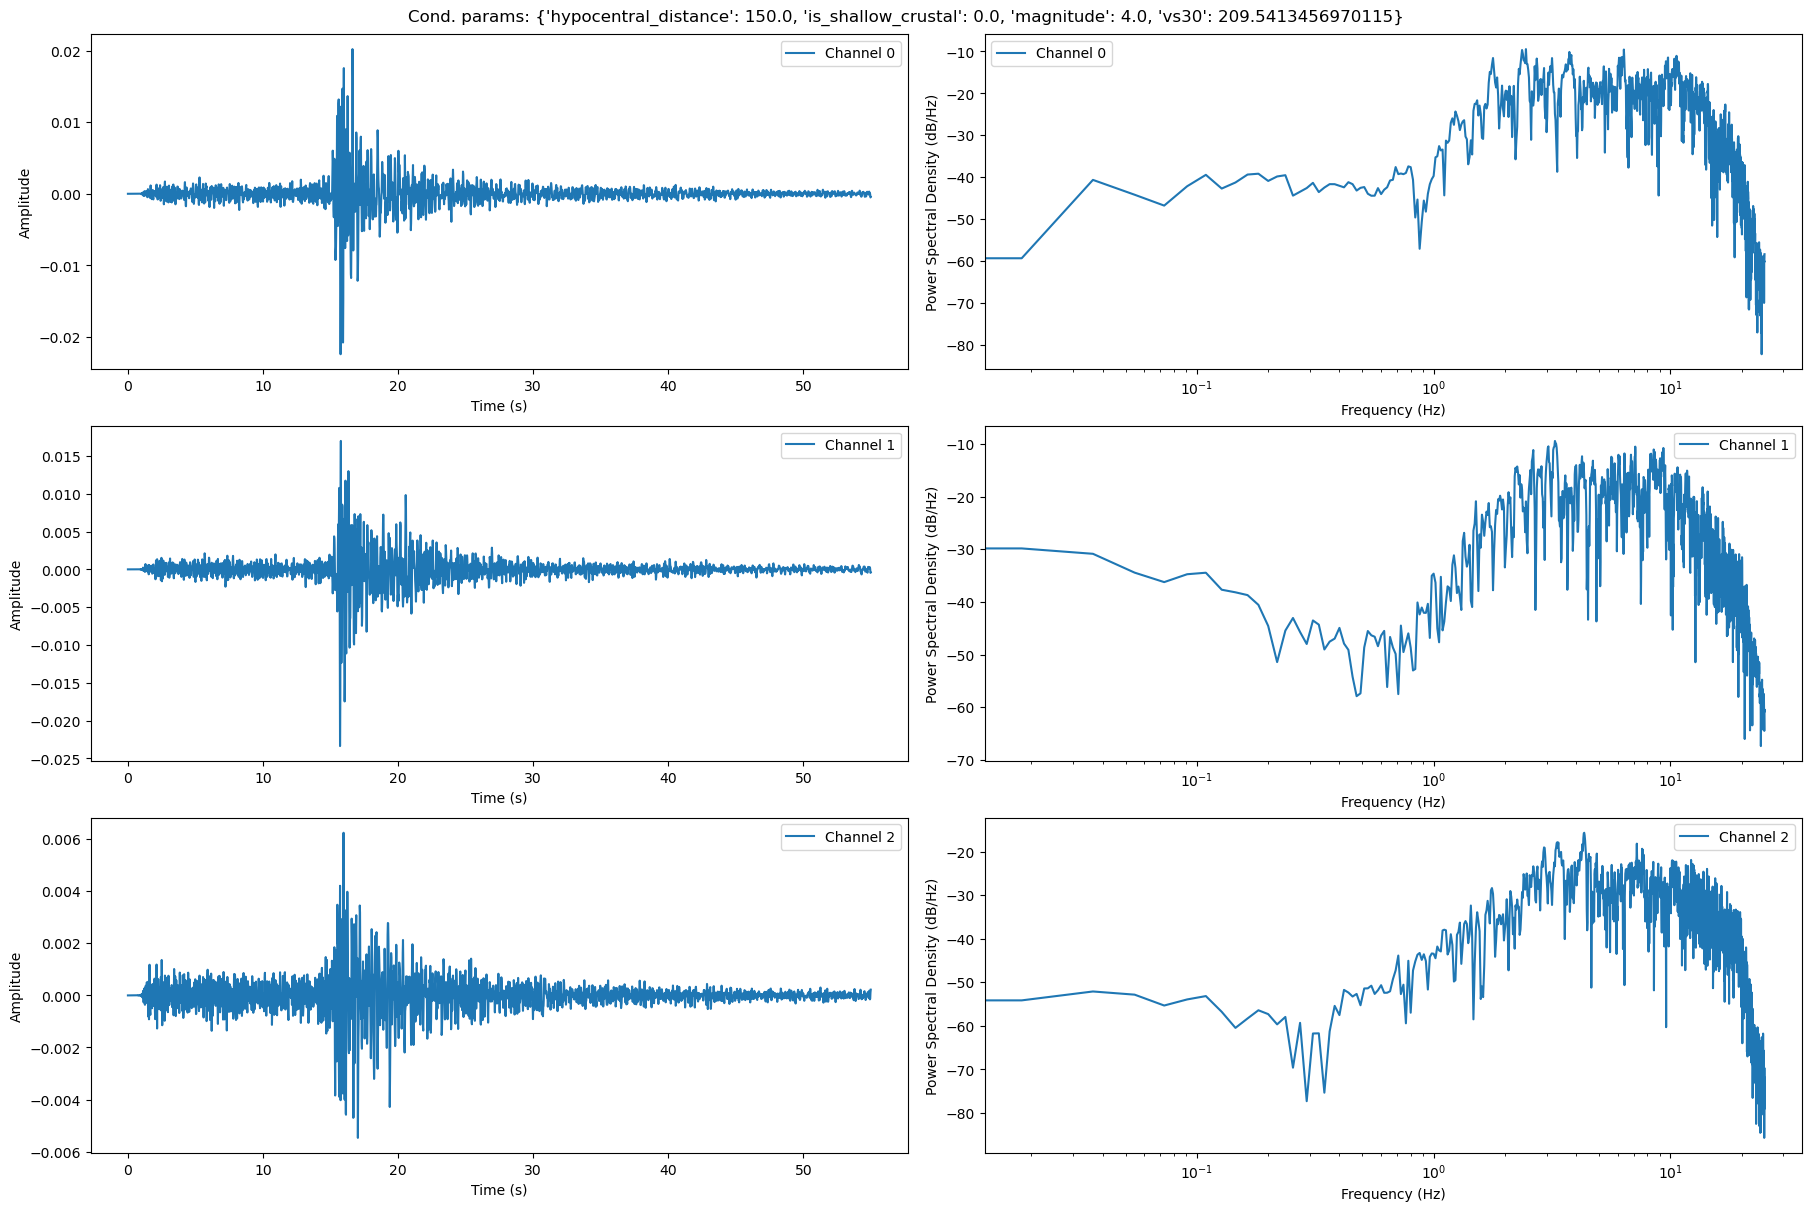

In [19]:
plot_waveform_and_psd(get_samples(data, num_samples=1))

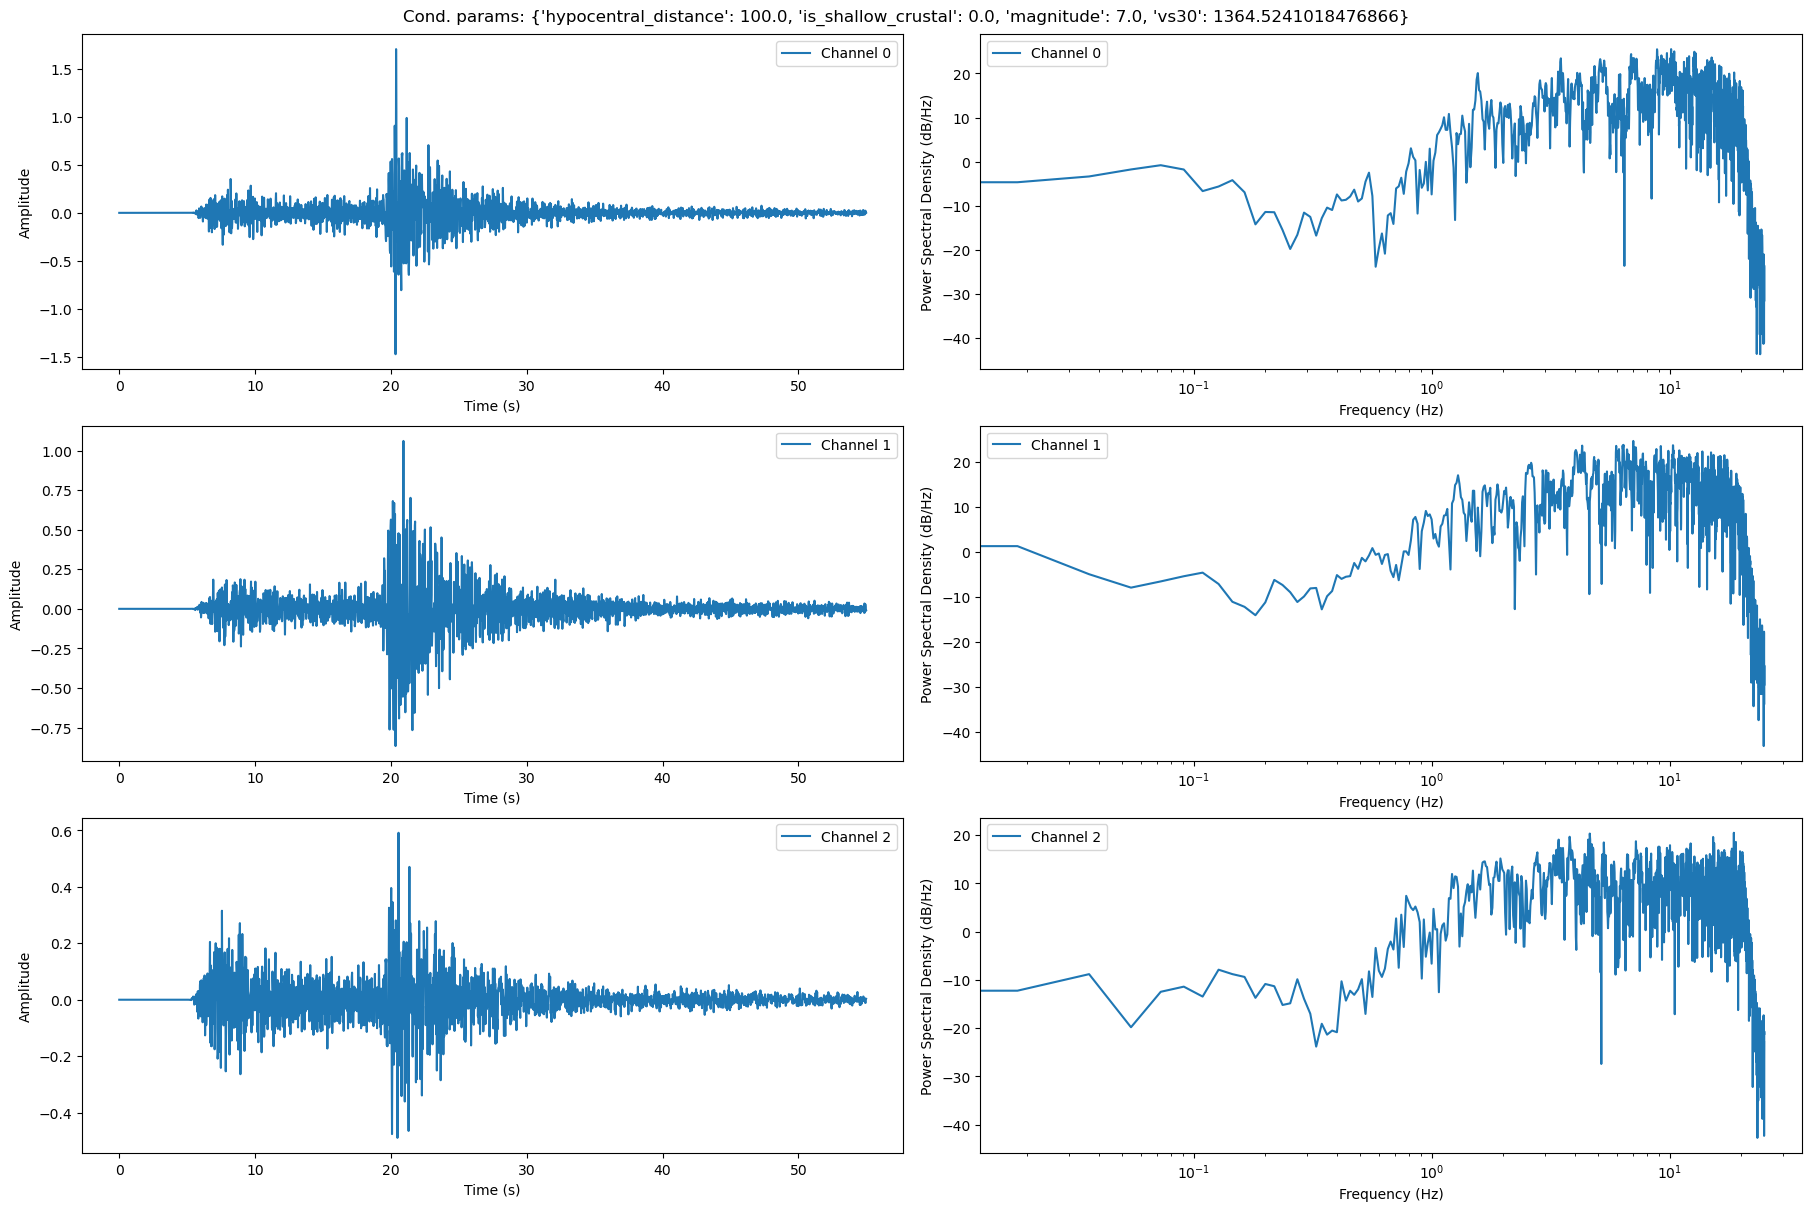

In [20]:
plot_waveform_and_psd(get_samples(data, indexes=[2]))

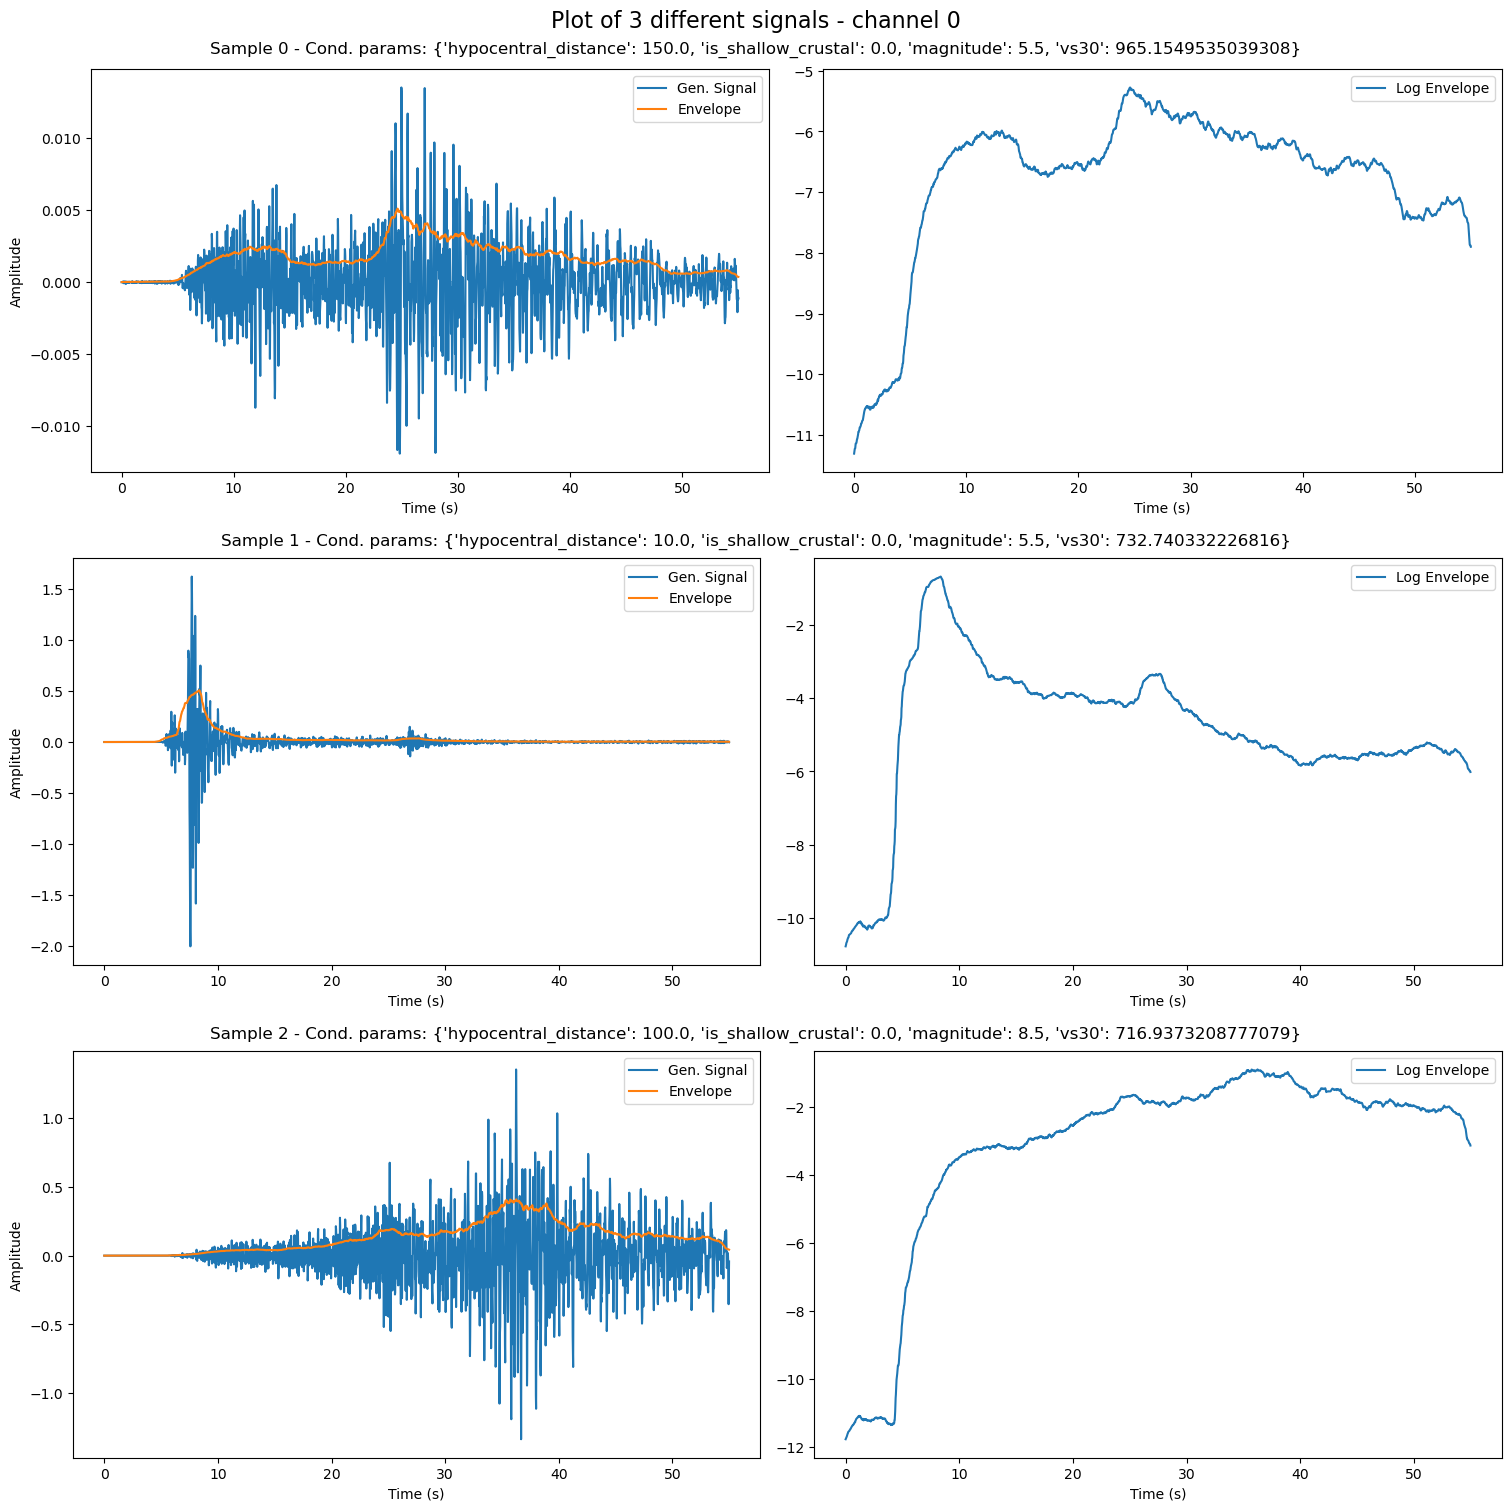

In [21]:
plot_waveforms(get_samples(data, num_samples=3), channel_index=0, plot_log_envelope=True)

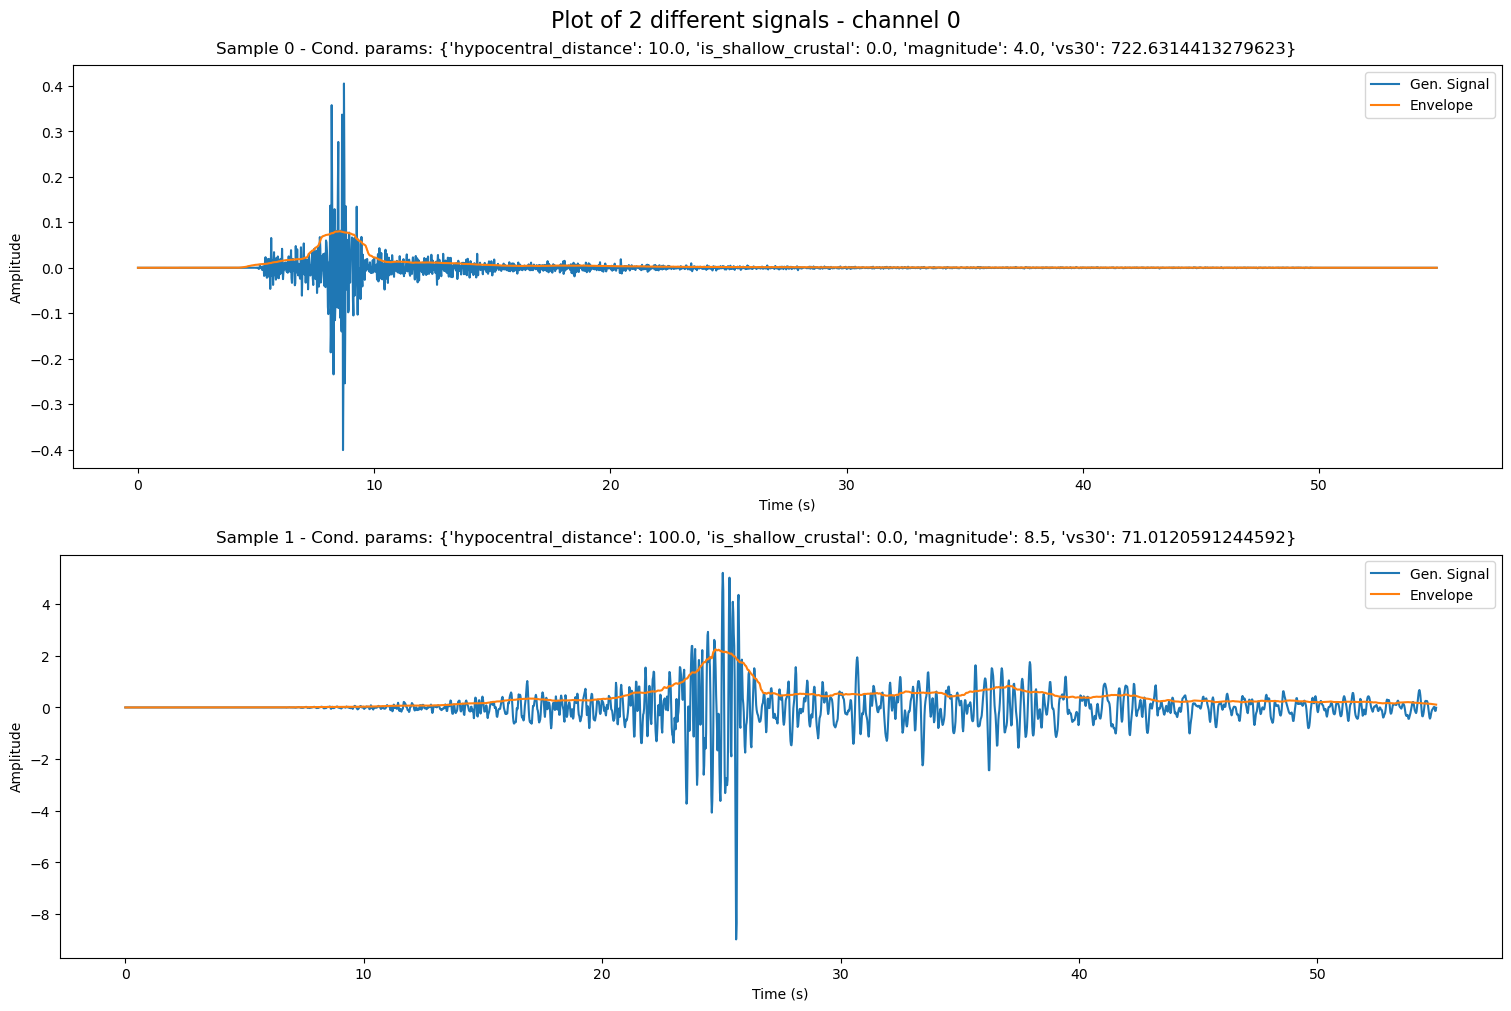

In [22]:
plot_waveforms(get_samples(data, num_samples=2), channel_index=0, plot_log_envelope=False)

## Batch Statistics

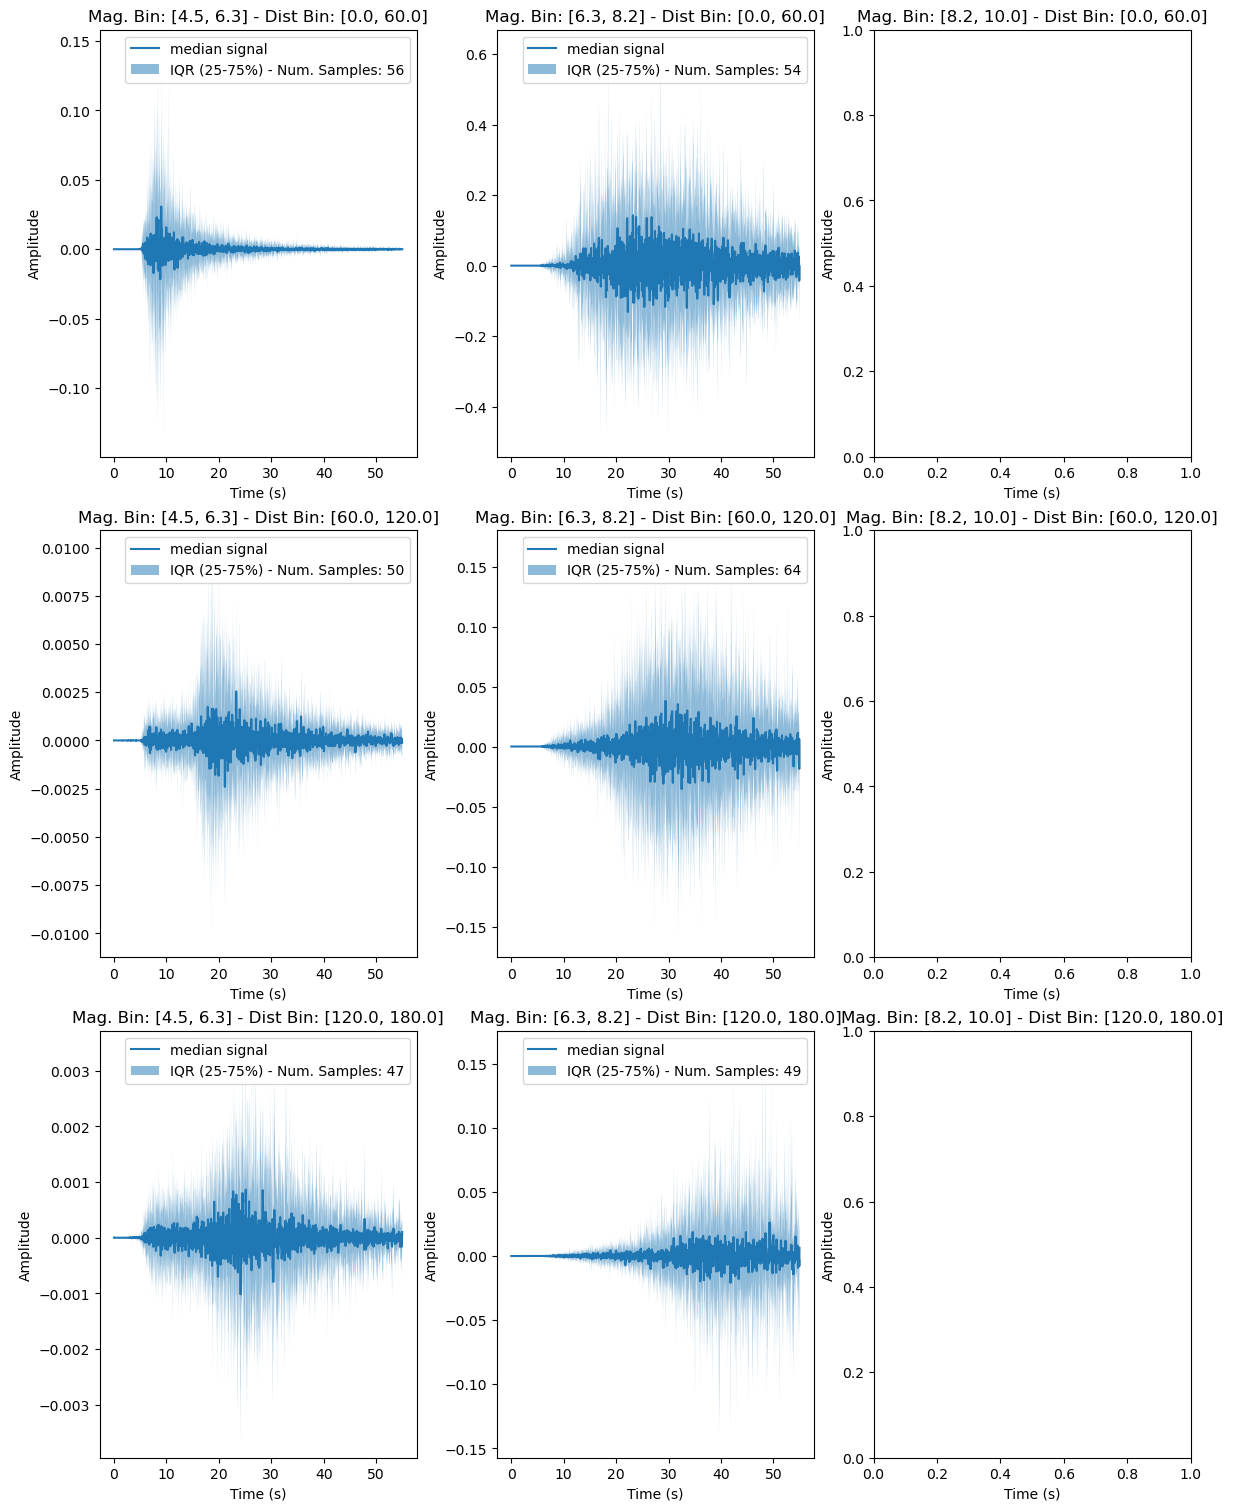

In [23]:
plot_by_bins(data, num_magnitude_bins=3, num_distance_bins=3, plot_type='waveform')

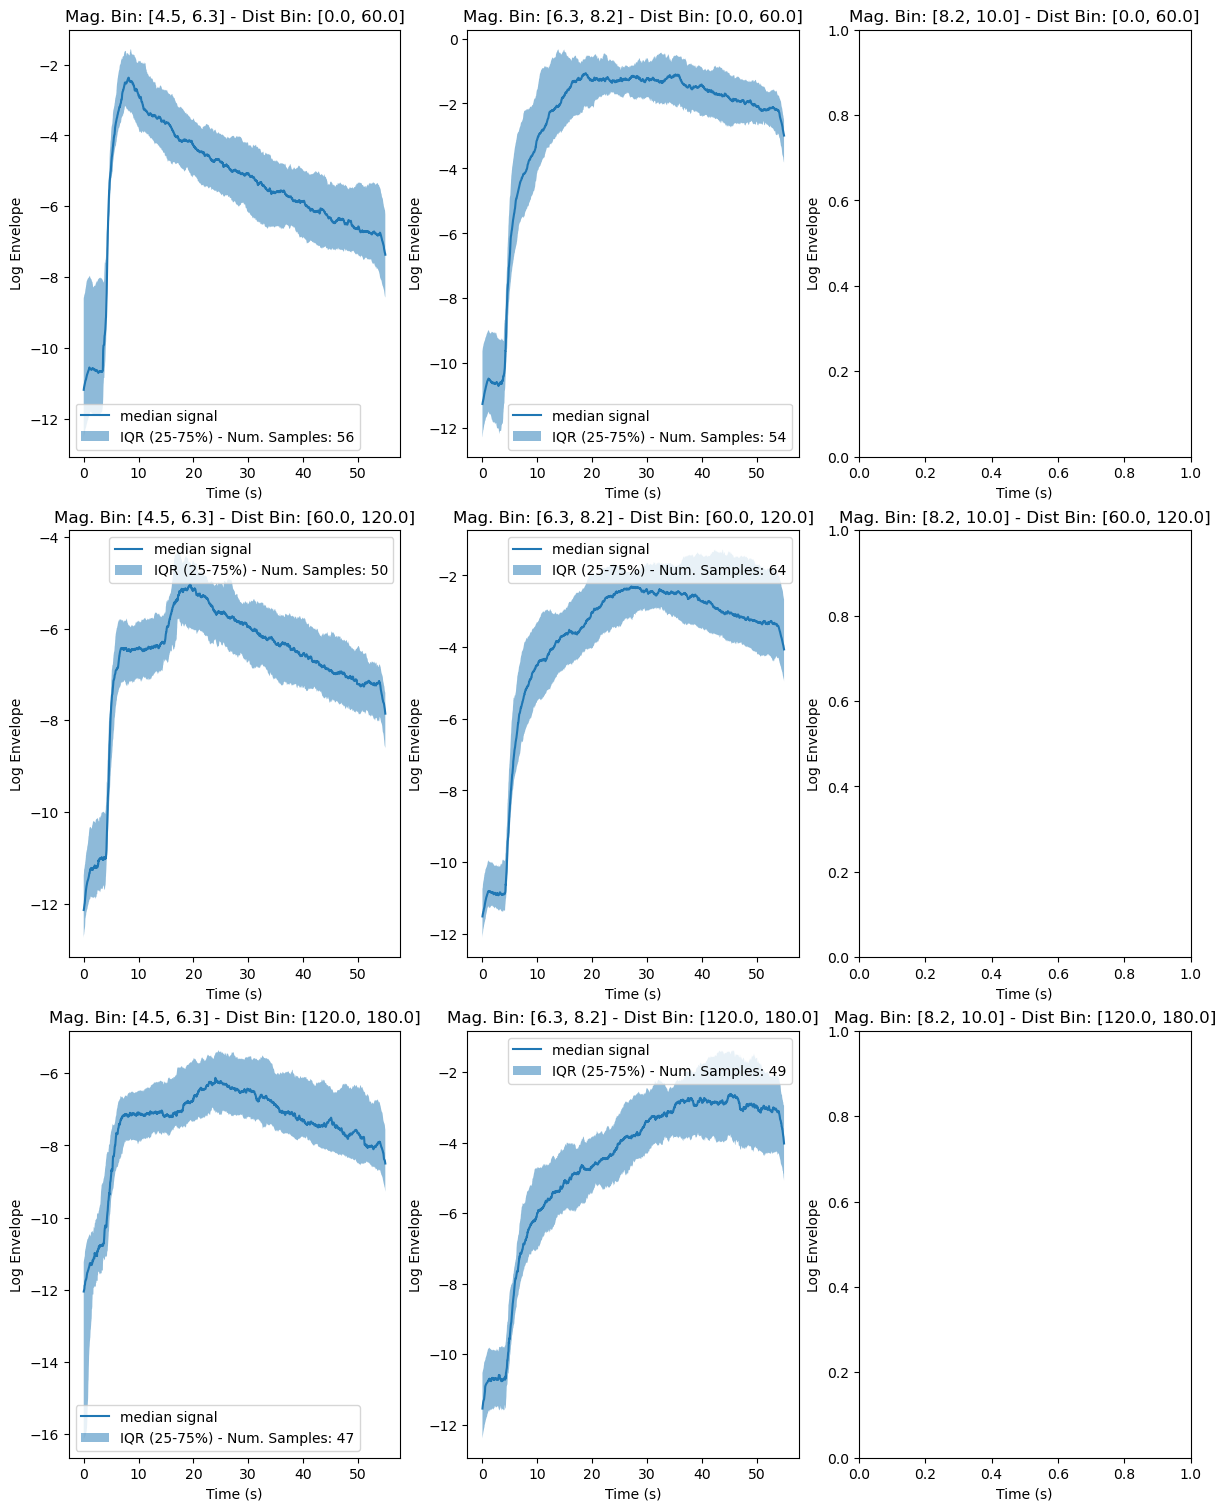

In [24]:
plot_by_bins(data, num_magnitude_bins=3, num_distance_bins=3, plot_type='log_envelope')

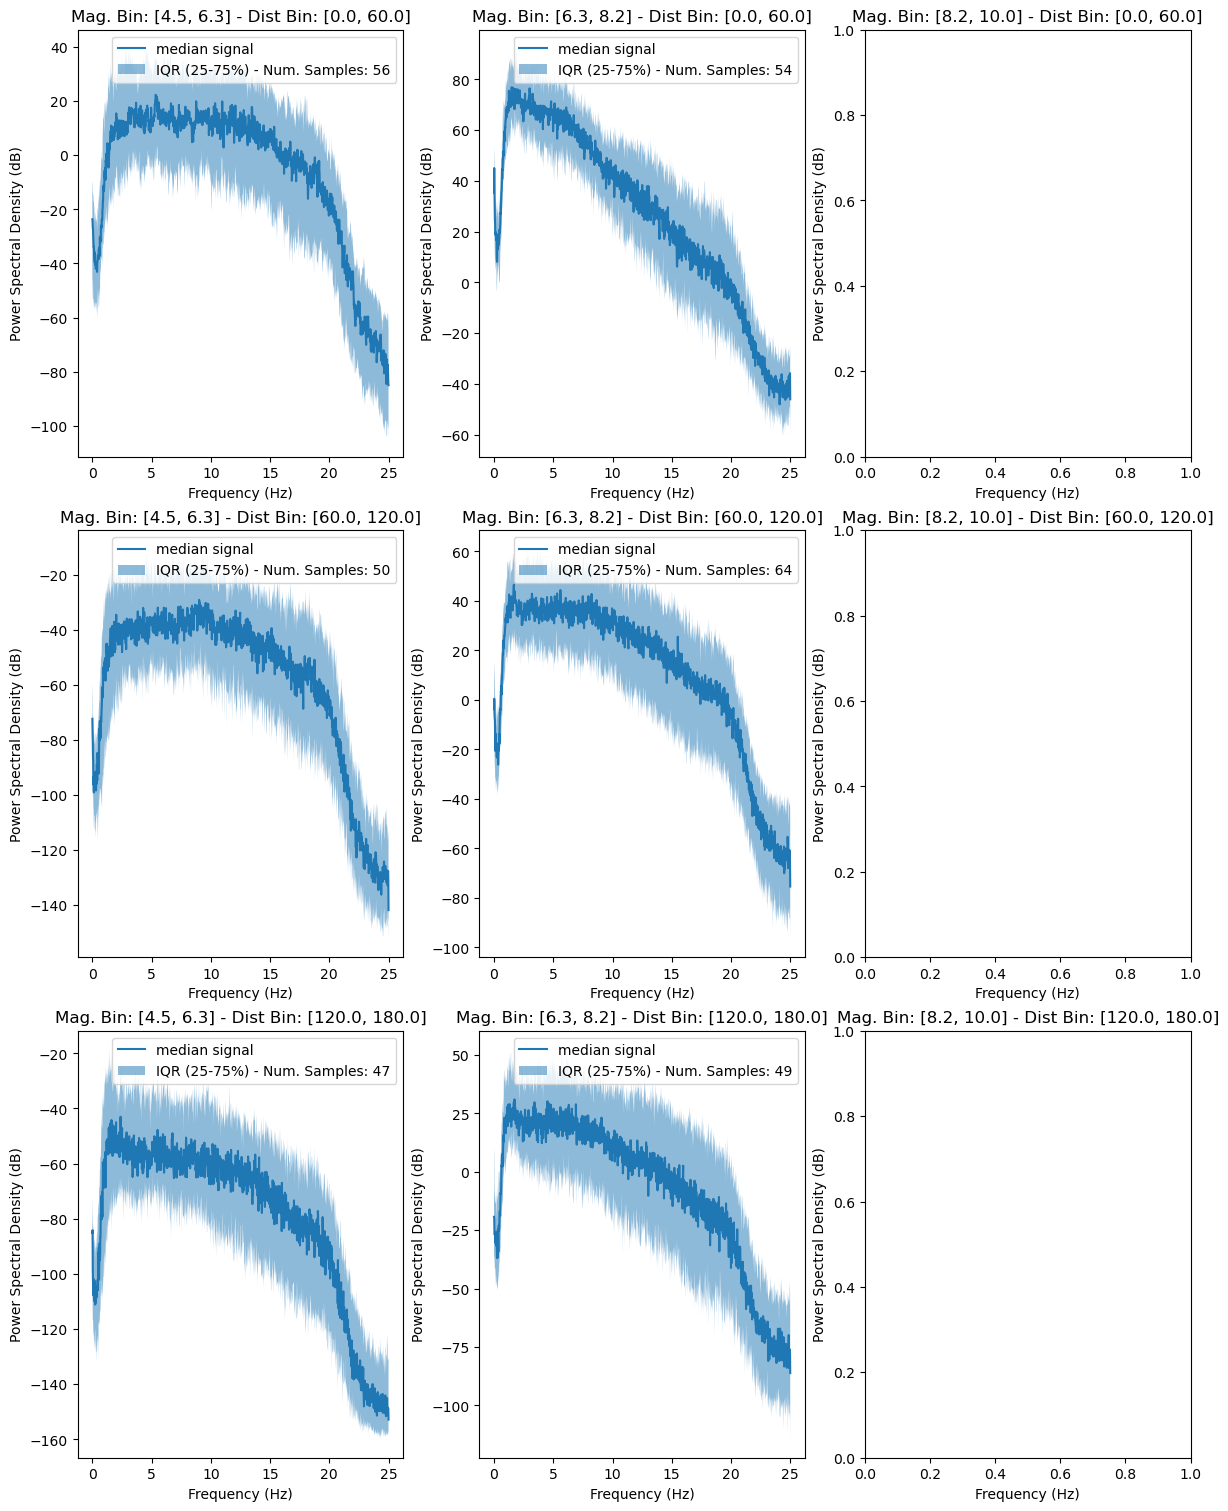

In [25]:
plot_by_bins(data, num_magnitude_bins=3, num_distance_bins=3, plot_type='power_spectral_density')

In [26]:
del data
del data_raw

## Evaluation

In [10]:
from tqdne.representations import Signal

test_dataset_path = config.datasetdir / config.data_test
train_dataset_path = config.datasetdir / config.data_train

test_dataset = RepresentationDataset(test_dataset_path, Signal(), pad=config.signal_length*downsampling, downsample=downsampling)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_dataset = RepresentationDataset(train_dataset_path, Signal(), pad=config.signal_length*downsampling, downsample=downsampling)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

real_dataset = ConcatDataset([train_dataset, test_dataset])
real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False)

Let's generate couple of samples with the same conditioning parameters to check the expressiveness of the model and check if it lies within the true data distribution. 

Batch 1/1


100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


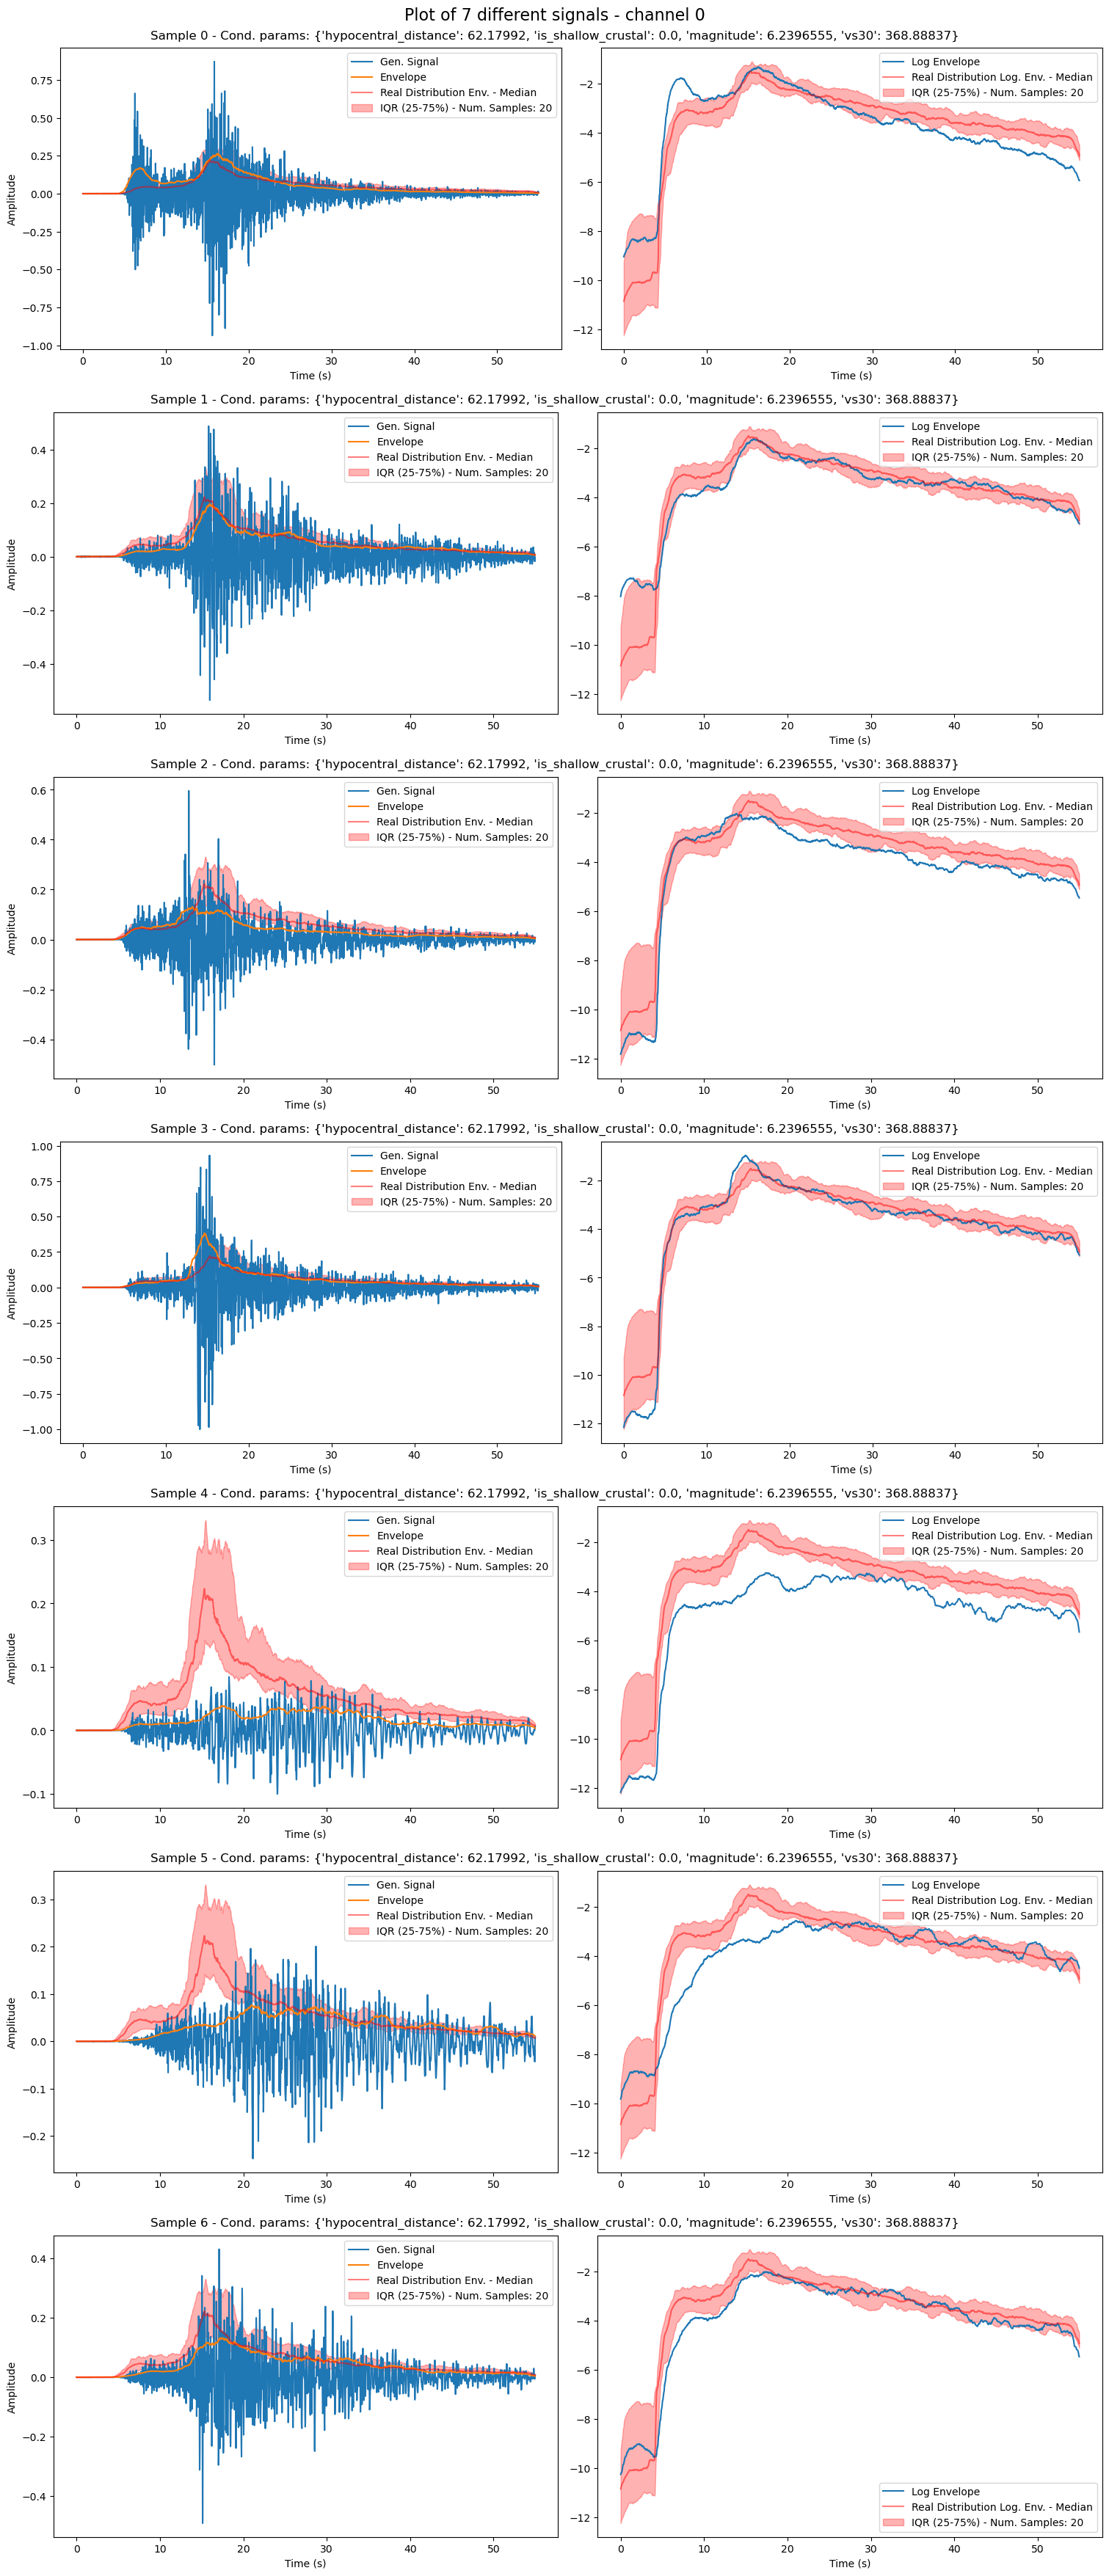

In [11]:
mag_bin = (6, 6.5)
dist_bin = (50, 70)
data_test_single_bin = test_dataset.get_data_by_bins(mag_bin, dist_bin, is_shallow_crustal=0)
cond_params_mean = data_test_single_bin['cond'].mean(axis=0).reshape(1,-1)
data_pred_single_bin = generate_data(model, model_data_representation=model_data_repr, raw_output=False, num_samples=7, cond_input=cond_params_mean, device=device.type)

plot_waveforms(data_pred_single_bin, test_waveforms=data_test_single_bin['waveform'])

Batch 1/1


100%|██████████| 100/100 [00:02<00:00, 41.40it/s]


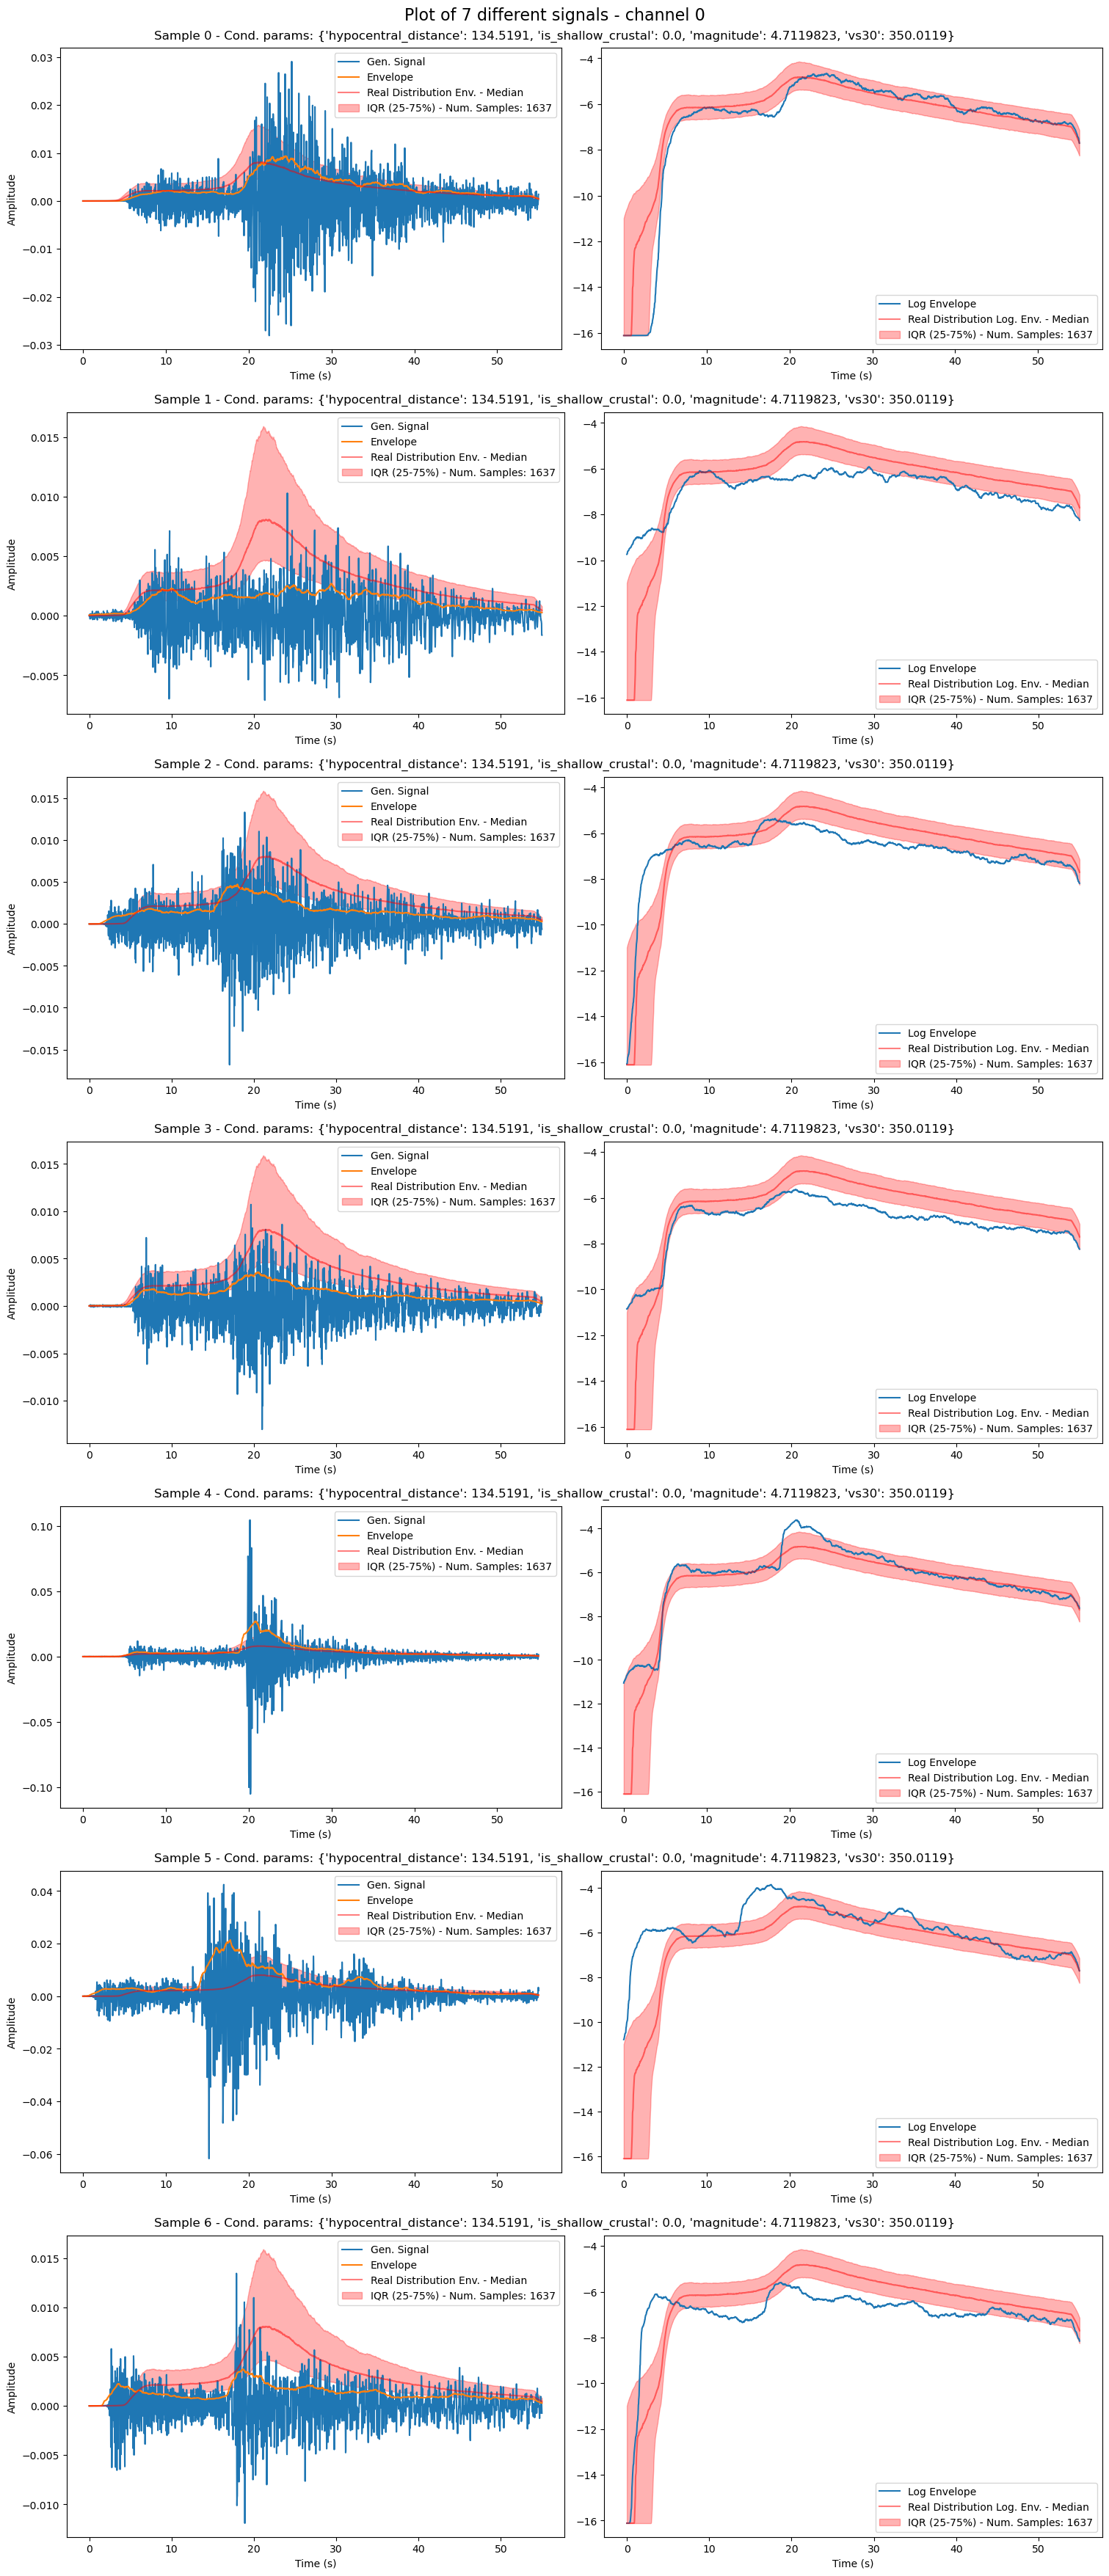

In [12]:
mag_bin = (4, 5)
dist_bin = (120, 150)
data_test_single_bin = test_dataset.get_data_by_bins(mag_bin, dist_bin, is_shallow_crustal=0)
cond_params_mean = data_test_single_bin['cond'].mean(axis=0).reshape(1,-1)
data_pred_single_bin = generate_data(model, model_data_representation=model_data_repr, raw_output=False, num_samples=7, cond_input=cond_params_mean, device=device.type)

plot_waveforms(data_pred_single_bin, test_waveforms=data_test_single_bin['waveform'])

Batch 1/1


100%|██████████| 100/100 [00:02<00:00, 41.55it/s]


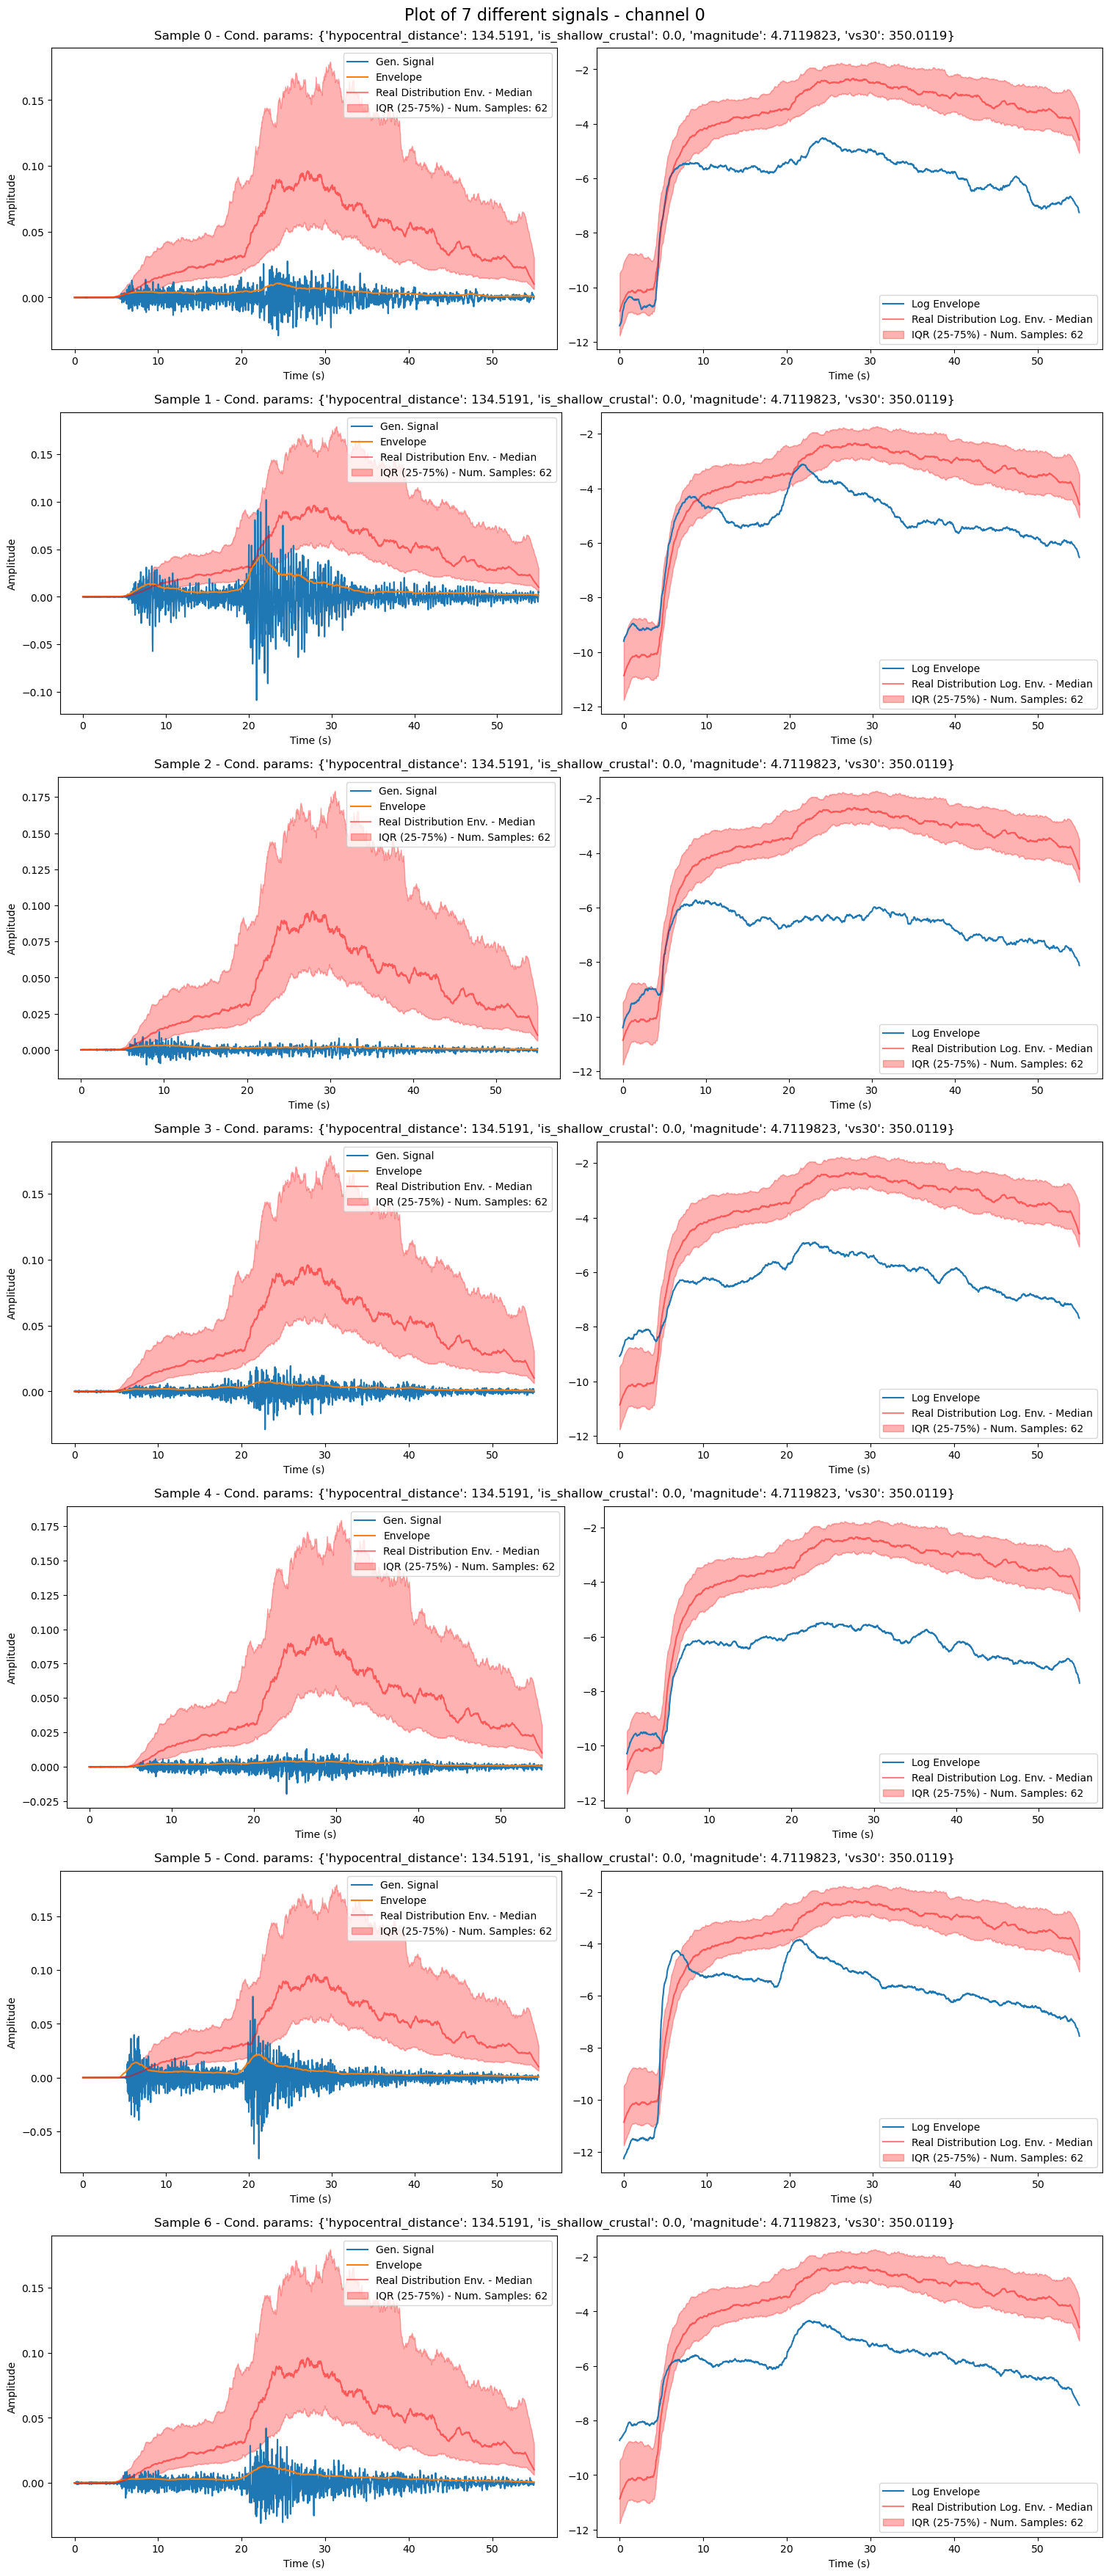

In [13]:
mag_bin = (6.5, 9.)
dist_bin = (120, 150)
data_real_single_bin = test_dataset.get_data_by_bins(mag_bin, dist_bin, is_shallow_crustal=0)
cond_params_mean = data_test_single_bin['cond'].mean(axis=0).reshape(1,-1)
data_pred_single_bin = generate_data(model, model_data_representation=model_data_repr, raw_output=False, num_samples=7, cond_input=cond_params_mean, device=device.type)

plot_waveforms(data_pred_single_bin, test_waveforms=data_real_single_bin['waveform'])

Let's now compare the statistics of the generated data wrt the real data.

In [11]:
real_data = {
    "waveforms": np.concatenate([test_dataset[:]['waveform'], train_dataset[:]['waveform']], axis=0),
    "cond": np.concatenate([test_dataset[:]['cond'], train_dataset[:]['cond']], axis=0)
}
real_data['waveforms'].shape, real_data['cond'].shape

((197370, 3, 2750), (197370, 4))

Now let's generate more samples to perform an analysis by dividing the data in bins (magnitude and distance). 

Let's save the generated data future use.

The data will be saved as a `dict` with keys `waveforms` and `cond` in the same place of the checkpoint of the selected model, with the same name of `ckpt`, except for the extension of the file (saved as a HDF5 `.hdf5` file).
The optimal approach for downloading the generated dataset to a local storage location is to replace the string `hdf5_filename` with the desired filename, thus enabling the file to be stored in the current directory. This file may then be downloaded via the integrated visual interface of VSCode or JupyterLab. 


In [12]:
# Save the generated waveforms along with the conditioning parameters
hdf5_filename = f"{str(ckpt).replace('.ckpt', '_new.hdf5')}"
hdf5_filepath = Path(hdf5_filename)

In [ ]:
# Generate waveforms with the same conditioning parameters of the real data
generated_raw_data = generate_data(
    model, 
    model_data_repr, 
    raw_output=True, 
    num_samples=real_data['waveforms'].shape[0], 
    cond_input=real_data['cond'], 
    device=device.type, 
    batch_size=batch_size,
    save_path=hdf5_filepath
)

generated_raw_data['waveforms'].shape, generated_raw_data['cond'].shape

Batch 1/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 2/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 3/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 4/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 5/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 6/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 7/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 8/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 9/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 10/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 11/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 12/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 13/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 14/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 15/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 16/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 17/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 18/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 19/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 20/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 21/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 22/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 23/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 24/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 25/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 26/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 27/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 28/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 29/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 30/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 31/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 32/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 33/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 34/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 35/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 36/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 37/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 38/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 39/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 40/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 41/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 42/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 43/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 44/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 45/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 46/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 47/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 48/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 49/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 50/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 51/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 52/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 53/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 54/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 55/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 56/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 57/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 58/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 59/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 60/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 61/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 62/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 63/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 64/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 65/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 66/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 67/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 68/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 69/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 70/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 71/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 72/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 73/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 74/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 75/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 76/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 77/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 78/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 79/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 80/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 81/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 82/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 83/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 84/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 85/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 86/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 87/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 88/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 89/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 90/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 91/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 92/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 93/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 94/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 95/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 96/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 97/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 98/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 99/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 100/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 101/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 102/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 103/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 104/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 105/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 106/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 107/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 108/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 109/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 110/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 111/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 112/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 113/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 114/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 115/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 116/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 117/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 118/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 119/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 120/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 121/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 122/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 123/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 124/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 125/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 126/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 127/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 128/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 129/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 130/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 131/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 132/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 133/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 134/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 135/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 136/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 137/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 138/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 139/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 140/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 141/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 142/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 143/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 144/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 145/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 146/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 147/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 148/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 149/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 150/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 151/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 152/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 153/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 154/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 155/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 156/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 157/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 158/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 159/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 160/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 161/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 162/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 163/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 164/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 165/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 166/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 167/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 168/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 169/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 170/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 171/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 172/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 173/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 174/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 175/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 176/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 177/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 178/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 179/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 180/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 181/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 182/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 183/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 184/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 185/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 186/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 187/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 188/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 189/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 190/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 191/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 192/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 193/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 194/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 195/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 196/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 197/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 198/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 199/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 200/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 201/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 202/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 203/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 204/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 205/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 206/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 207/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 208/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 209/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 210/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 211/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 212/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 213/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 214/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 215/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 216/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 217/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 218/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 219/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 220/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 221/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 222/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 223/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 224/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 225/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 226/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 227/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 228/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 229/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 230/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 231/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 232/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 233/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 234/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 235/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 236/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 237/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 238/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 239/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 240/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 241/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 242/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 243/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 244/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 245/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 246/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 247/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 248/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 249/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 250/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 251/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 252/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 253/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 254/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 255/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 256/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 257/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 258/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 259/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 260/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 261/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 262/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 263/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 264/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 265/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 266/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 267/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 268/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 269/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 270/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 271/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 272/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 273/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 274/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 275/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 276/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 277/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 278/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 279/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 280/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 281/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 282/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 283/616


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Batch 284/616


  2%|▏         | 2/100 [00:00<00:29,  3.35it/s]

Let's check the raw outputs by comparing them statistically with real data in the representation domain. 

In [41]:
plot_raw_output_distribution(generated_raw_data["waveforms"], real_dataset[:]['waveform'], model_data_repr)

TypeError: '<' not supported between instances of 'slice' and 'int'

In [13]:
# check if generated_data is available
if 'generated_data' in locals():
    generated_data = {"waveforms": model_data_repr.invert_representation(generated_raw_data['waveforms']), "cond": generated_raw_data['cond']}
    del generated_raw_data
    # if samples are available in a preexisting file, append the new samples to generated_data
    if hdf5_filepath.exists():
        with h5py.File(hdf5_filepath, 'r') as f:
            generated_data = {k: np.concatenate([generated_data[k], f[k][:]], axis=0) for k in generated_data.keys()}
else:
    # load the file hdf5_filename
    with h5py.File(hdf5_filepath, 'r') as f:
        generated_data = {"waveforms": f['waveforms'][:], "cond": f['cond'][:]}

generated_data['waveforms'].shape, generated_data['cond'].shape

((197370, 3, 2750), (197370, 4))

And let's now compare the generated data against the real ones. 

In [14]:
distance_bins = [(0, 40), (40, 60), (60, 80), (80.0, 120.), (120., 150.), (150., 200.)]
magnitude_bins = [(4.5, 5.0), (5., 5.5), (5.5, 6.5), (6.5, 7.5)]

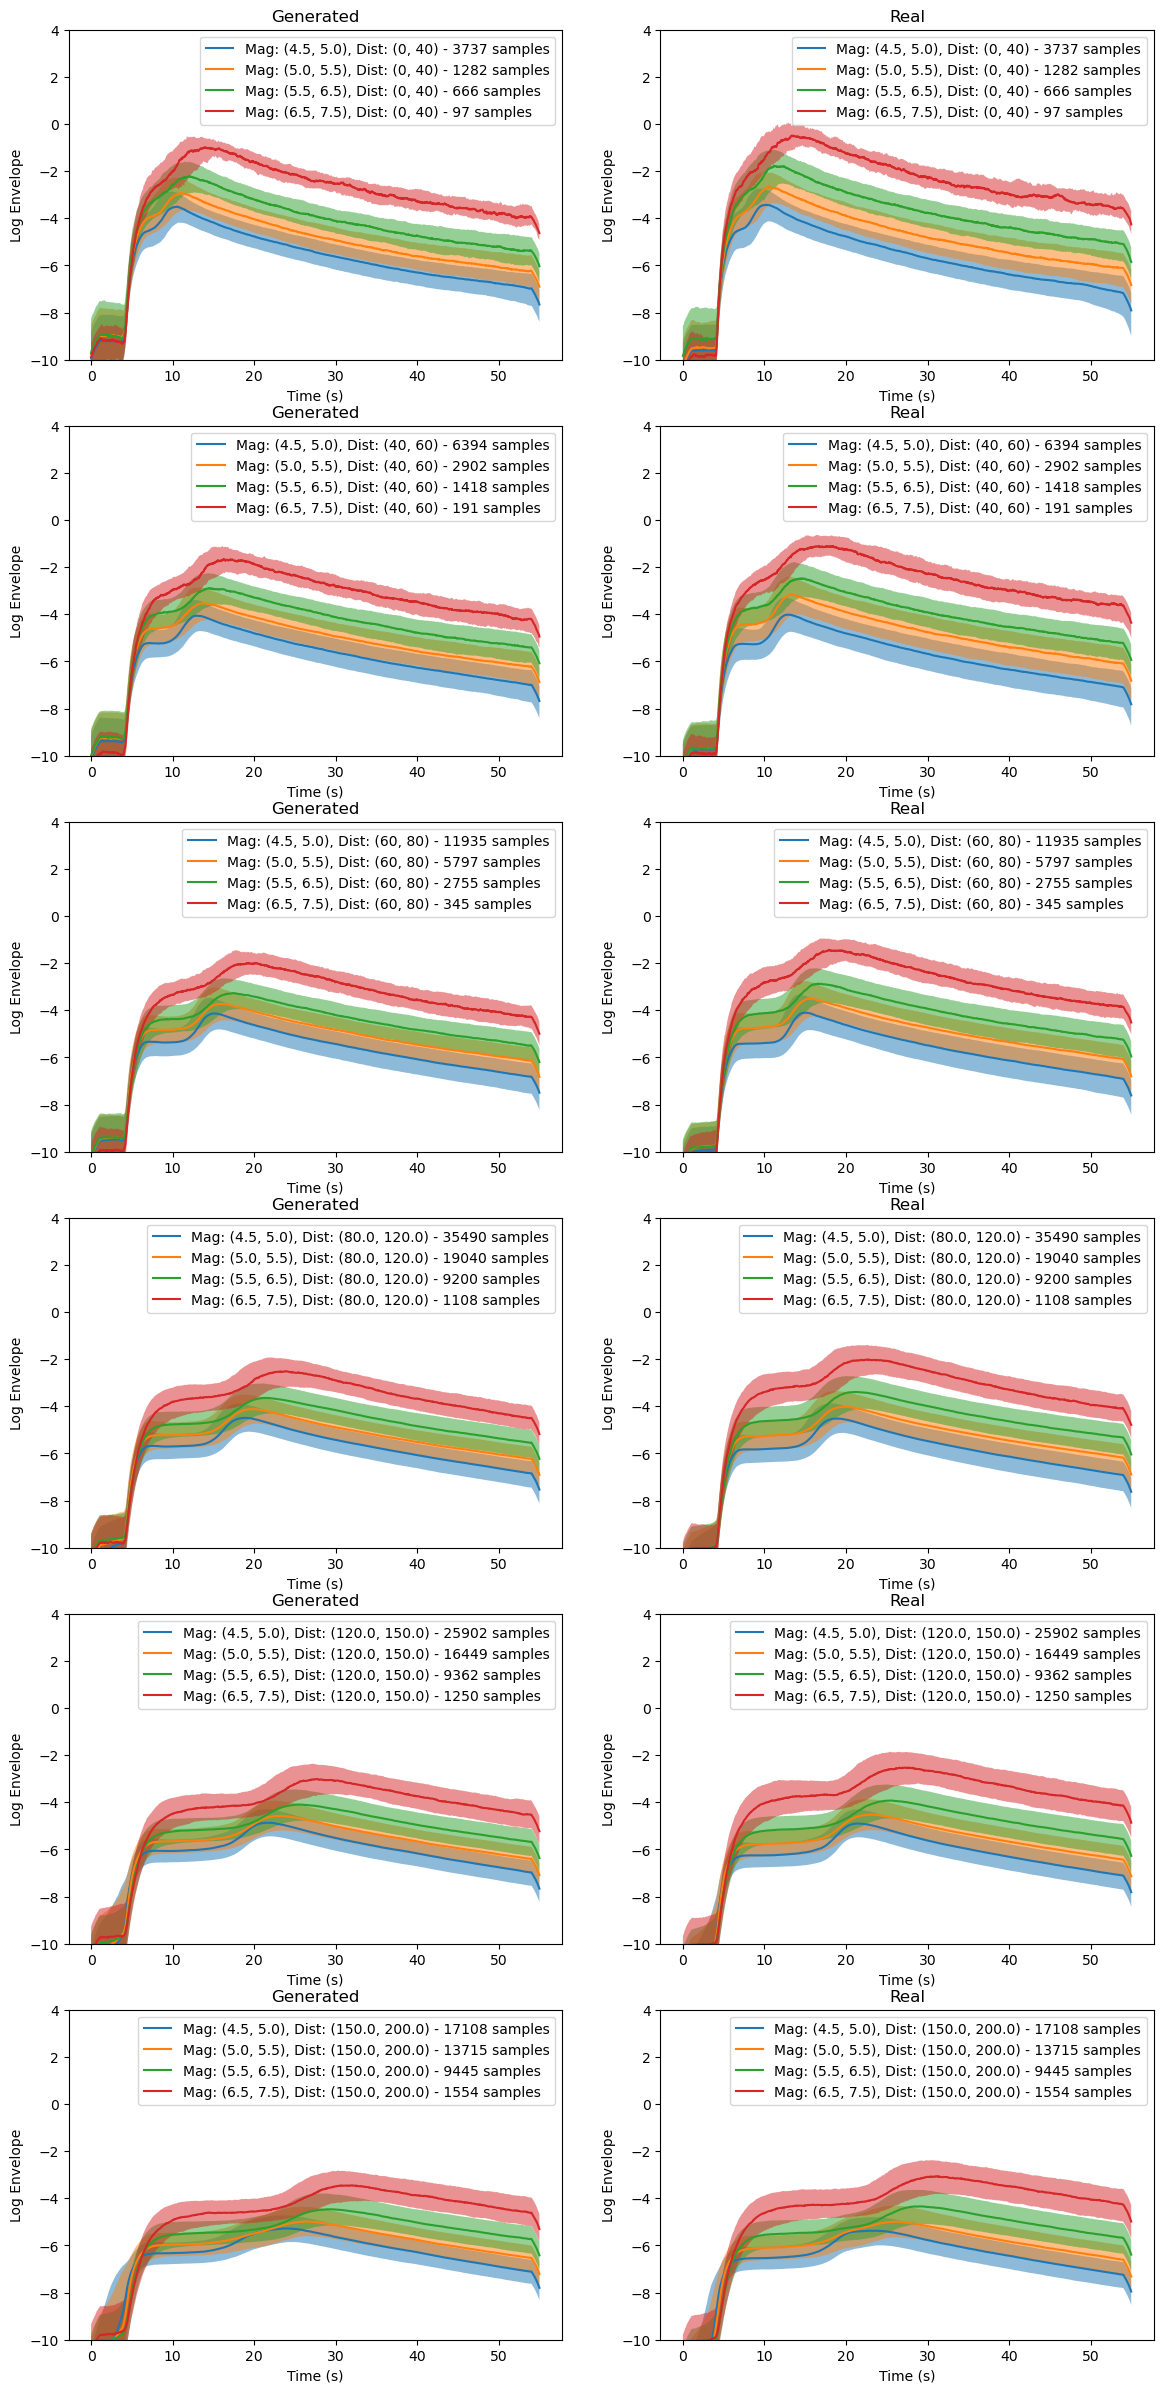

In [15]:
plot_bins(
    plot_type='log_envelope',
    distance_bins=distance_bins,
    magnitude_bins=magnitude_bins,
    channel_index=0,
    test_data=real_data, 
    data=generated_data, 
    model=model,
    model_data_representation = model_data_repr
)

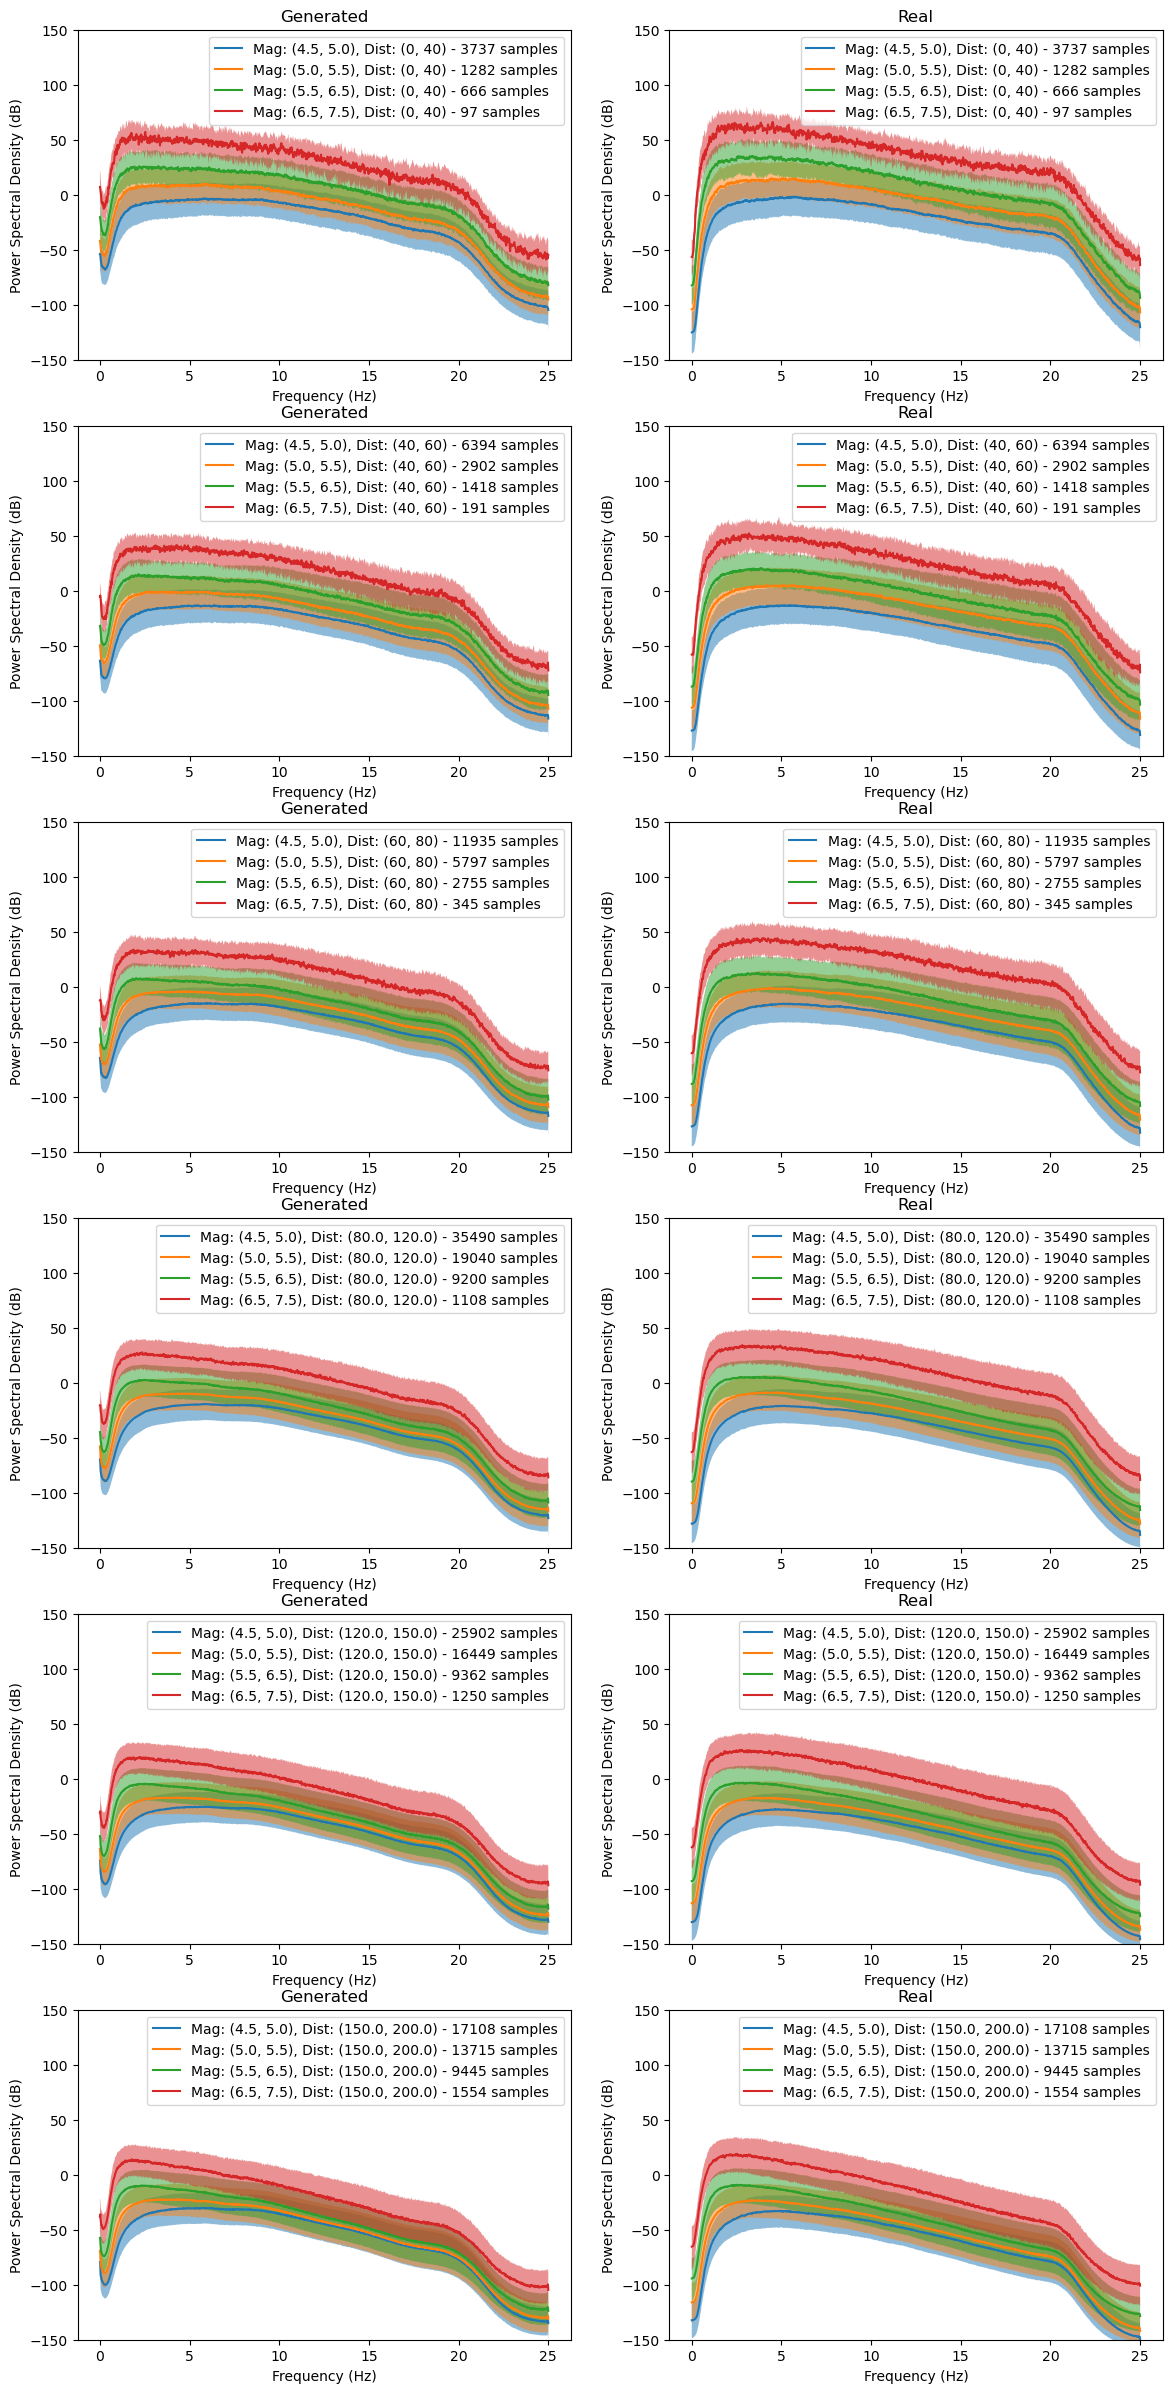

In [16]:
plot_bins(
    plot_type='power_spectral_density',
    distance_bins=distance_bins,
    magnitude_bins=magnitude_bins,
    channel_index=0,
    test_data=real_data, 
    data=generated_data, 
    model=model,
    model_data_representation=model_data_repr
)

Visualize the whole distribution in terms of Power Spectral Density and Envelope. 

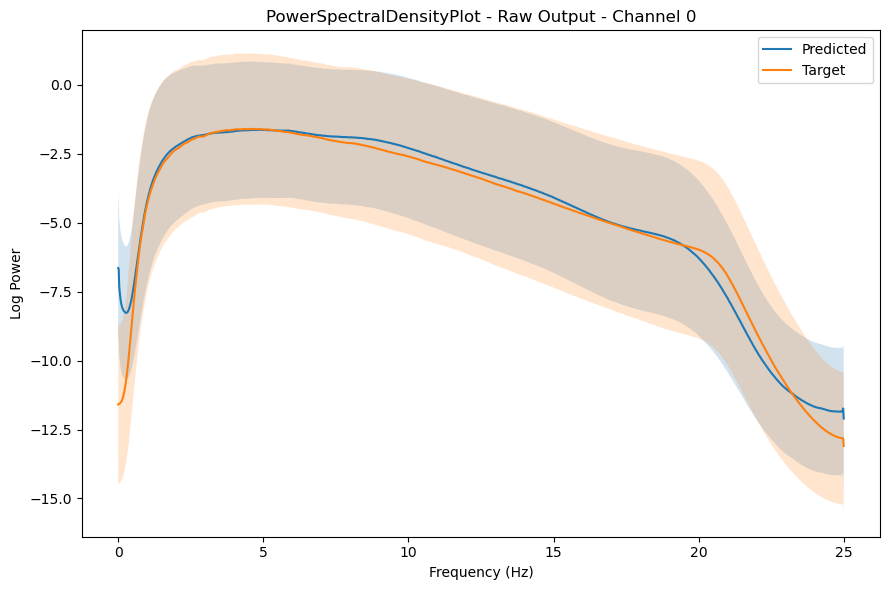

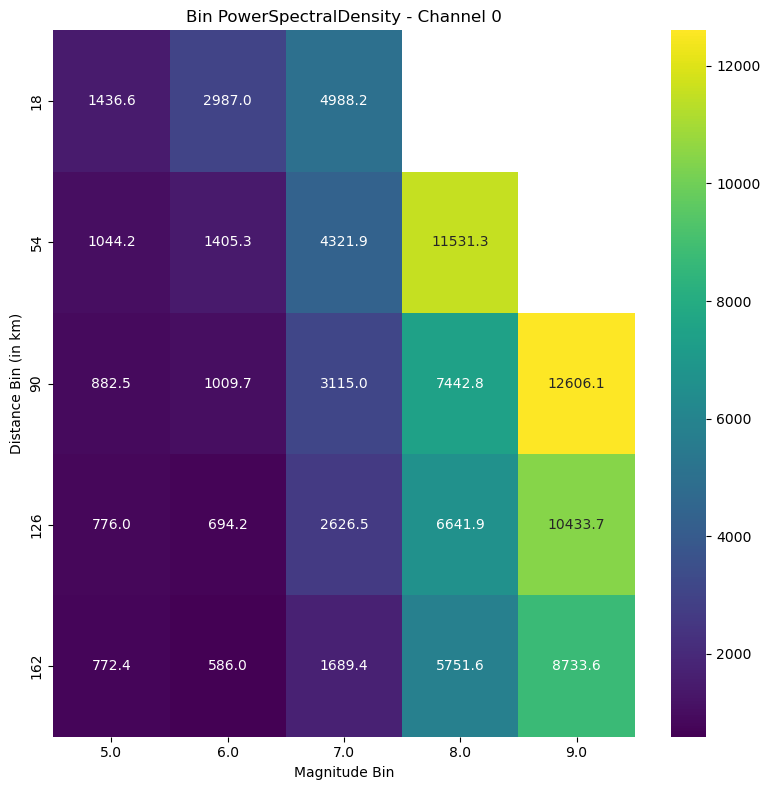

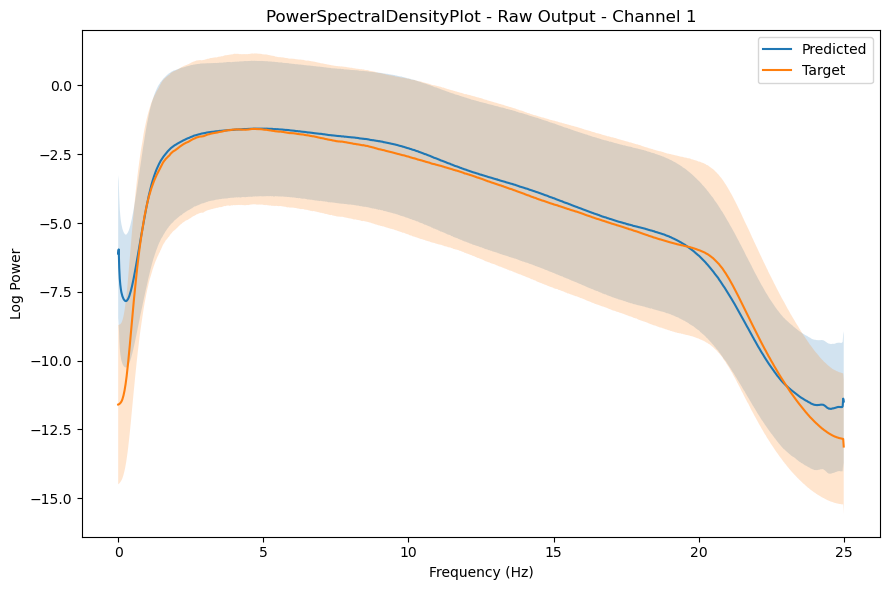

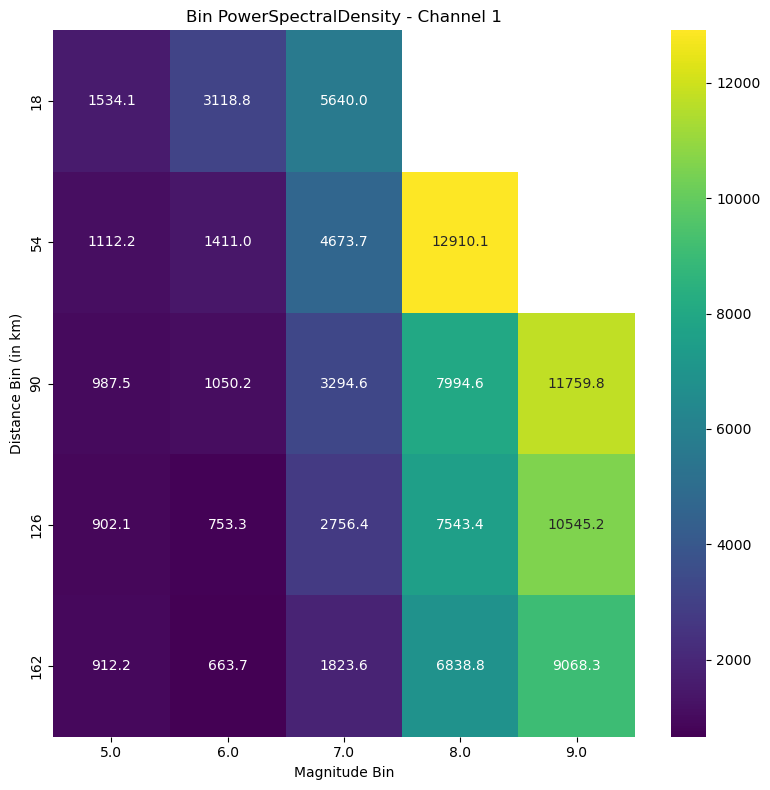

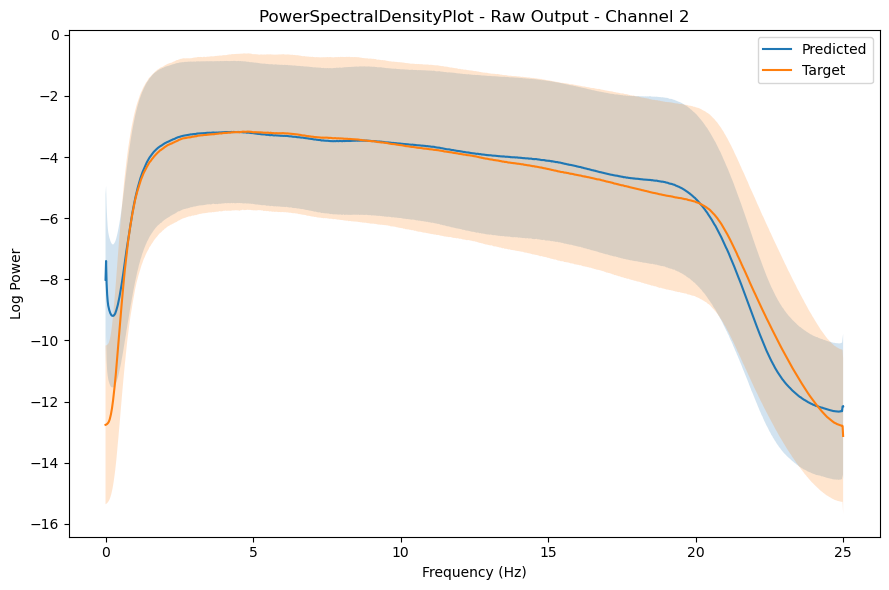

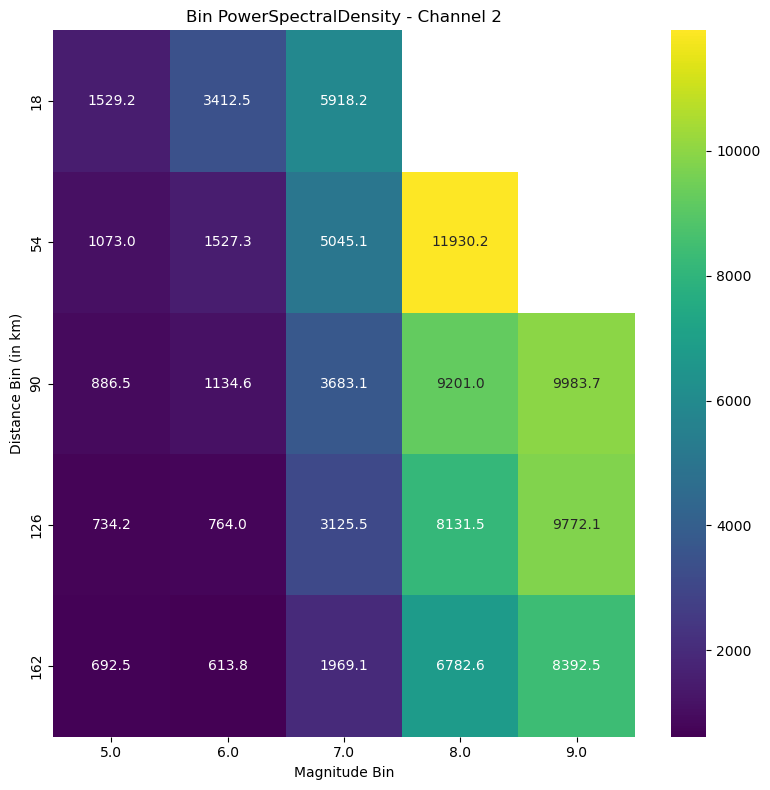

In [17]:
from tqdne.plot import PowerSpectralDensityPlot, BinPlot
from tqdne.metric import PowerSpectralDensity

psd_metrics = [PowerSpectralDensity(fs, channel=channel, invert_representation=False) for channel in range(n_channels)]
psd_plots = [PowerSpectralDensityPlot(fs, channel, invert_representation=False) for channel in range(n_channels)]
for i, psd in enumerate(psd_metrics):
    psd_plots[i](preds=generated_data['waveforms'], target=real_data['waveforms'])
    psd(preds=generated_data['waveforms'], target=real_data['waveforms'])    
    psd_bin = BinPlot(psd, num_mag_bins=5, num_dist_bins=5)
    psd_bin(preds=generated_data['waveforms'], target=real_data['waveforms'], cond=real_data['cond'])
       

In [ ]:
from tqdne.plot import LogEnvelopePlot
from tqdne.metric import LogEnvelope

logenv_metrics = [LogEnvelope(channel=channel, invert_representation=False) for channel in range(n_channels)]
logenv_plots = [LogEnvelopePlot(fs, channel, invert_representation=False) for channel in range(n_channels)]
for i, logenv in enumerate(logenv_metrics):
    logenv_plots[i](preds=generated_data['waveforms'], target=real_data['waveforms'][:, :, :signal_length])
    logenv(preds=generated_data['waveforms'], target=real_data['waveforms'][:, :, :signal_length])    
    logenv_bin = BinPlot(psd, num_mag_bins=5, num_dist_bins=5)
    logenv_bin(preds=generated_data['waveforms'], target=real_data['waveforms'], cond=real_data['cond'])

### Evaluation using a classifier

In [17]:
classifier_path = Path("/users/abosisio/scratch/tqdne/outputs/classifier-2D-32Chan-(1, 2, 4, 8)Mult-2ResBlocks-4AttHeads_LogSpectrogram-stft_ch:128-hop_size:32/name=0_epoch=45-val_loss=0.87.ckpt")
classifier, classifier_data_repr, classifier_ckpt = load_model(classifier_path, use_ddim=False)
classifier_ckpt

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


'/users/abosisio/scratch/tqdne/outputs/classifier-2D-32Chan-(1, 2, 4, 8)Mult-2ResBlocks-4AttHeads_LogSpectrogram-stft_ch:128-hop_size:32/name=0_epoch=45-val_loss=0.87.ckpt'

#### Compute Fréchet Inception Distance (FID)

In [18]:
from tqdne.metric import compute_fid

fid_train_vs_test = compute_fid(
    classifier.get_embeddings(train_dataloader, classifier_data_repr), 
    classifier.get_embeddings(test_dataloader, classifier_data_repr)
)
print(f"FID baseline (train (N={len(train_dataset)}) vs test (N={len(test_dataset)})): {fid_train_vs_test}")


fid_real_vs_generated = compute_fid(
    classifier.get_embeddings(real_dataloader, classifier_data_repr), 
    classifier.get_embeddings(generated_data['waveforms'], classifier_data_repr)
)
print(f"FID (real (N={len(real_dataset)}) vs generated (N={generated_data['waveforms'].shape[0]})): {fid_real_vs_generated}")


100%|██████████| 47/47 [00:47<00:00,  1.01s/it]


FID baseline (train (N=182523) vs test (N=14847)): 0.004295315069999361


100%|██████████| 256/256 [06:18<00:00,  1.48s/it]


FID (real (N=197370) vs generated (N=197370)): 9.117335839436187


#### Compute Inception Score

In [19]:
from tqdne.metric import compute_inception_score

print("Inception Score:", compute_inception_score(classifier.get_probabilities(generated_data['waveforms'], classifier_data_repr)))

100%|██████████| 256/256 [06:14<00:00,  1.46s/it]

Inception Score: 3.0971744829950474


## TODOs

In [ ]:
# TODO: widgets do not work

# from tqdne.metric import PowerSpectralDensity, BinMetric
# import ipywidgets as widgets
# from functools import partial

# metrics = {"Power Spectral Density": partial(PowerSpectralDensity, fs=config.fs)}

# # Create a dropdown for selecting the metric
# metric_dropdown = widgets.Dropdown(
#     options=metrics.keys(),
#     description='Metric:',
# )

# # Create a slider for selecting the channel
# channel_slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=2,
#     step=1,
#     description='Channel:',
#     disabled=False,
#     continuous_update=False,
#     orientation='horizontal',
#     readout=True,
#     readout_format='d'
# )


# # Bin plot checkbox
# bin_plot_checkbox = widgets.Checkbox(
#     value=False,
#     description='Plot bins',
#     disabled=False,
#     indent=True,
# )

# # Create a slider for selecting the number of bins
# num_bins_slider = widgets.IntSlider(
#     value=10,
#     min=1,
#     max=50,
#     step=1,
#     description='Num bins:',
#     disabled=False,
#     continuous_update=False,
#     orientation='horizontal',
#     readout=True,
#     readout_format='d'
# )

# # Function to update the plot
# def update_plot(metric_name, bin_plot, num_bins=10, channel=0):
#     metric = metrics[metric_name](channel=channel)
#     if bin_plot:
#         metric = BinMetric(metric, num_mag_bins=num_bins, num_dist_bins=num_bins)

#     # Compute the metric
#     metric.reset()
#     metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
#     metric.plot().show()

# # Create interactive plot
# widgets.interact(update_plot, metric_name=metric_dropdown, channel=channel_slider, bin_plot=bin_plot_checkbox, num_bins=num_bins_slider)



In [ ]:
print('done')

In [ ]:
# # Save the data to obspy format
# from obspy import Stream, Trace

# # Convert waveforms to Trace objects
# traces = [Trace(data=waveform, header={k:v for k, v in get_cond_params_dict(pred_data["cond"][i])}) for i, waveform in enumerate(pred_data["waveforms"])]

# # Create a Stream object
# st = Stream(traces=traces)

# # Save the Stream object to a file
# st.write("generated_waveforms.mseed", format="MSEED", reclen=512, encoding="FLOAT64")
